# Credit Risk Predictor Project

## Start-up idea introduction
New home is often unreachable for people (as specially for young ones) due to enormous price in comparison to average salary. For this reason home credits appeared on the market giving great opportunity to get your own floor earlier.
If the decision whether give the person a home credit, was made wrongly, it might create a great risk for banks and customers as well. There are many reasons why customers may be insolvent: incorrect money habits, unstable job, sudden death, divorce etc. On the other hand, being too conservative while making a home credit decision, might deprive a person a great life-opportunity and banks' profits.

Wouldn't be perfect if home credits, would be given only to people who can handle it? In that scenario, banks would have safer more constant profits and credits costs might decrease!!
This is why, our group decided to create a machine learning model which will make a personal prediction and asses a home credit risk for the client who apply a credit!

Our proof-of-concept will use sample dataset from kaggle (https://www.kaggle.com/competitions/home-credit-default-risk/data)*. This dataset is a model example of information that banks probably collect on daily basis.
**Anna Montoya, inversion, KirillOdintsov, and Martin Kotek. Home Credit Default Risk. https://kaggle.com/competitions/home-credit-default-risk, 2018. Kaggle.*
On this data, we will train multiple ML models and deploy one of them in Google Cloud Platform (GCP).

The project consist of 2 parts:\
I. EDA (`I_EDA.ipynb`):
1. Feature engineering and feature selection using LightGBM feature importance
2. Precise EDA of selected features.

II. ML modeling (`II_ML_modeling&deployment.ipynb`):

3. Training ML models on selected features
4. Selecting the best model and its hyperparameter tuning
5. Creating a streamlit app (`app.py`)
6. Deploying an app with trained ML model underhood on Google Cloud Platform

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

sklearn module

In [ ]:
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    cross_val_predict,
    train_test_split,
)
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
import lightgbm as lgb

## [Optional] Downloading datasets
User can download all dataset files using theirown kaggle account:\
Logging to kaggle repository using User's kaggle credentails from kaggle_credentials.py

In [3]:
# import os
# from credentials import API_key

# os.environ["KAGGLE_USERNAME"] = API_key["username"]
# os.environ["KAGGLE_KEY"] = API_key["key"]

Downloading all files

In [4]:
#!kaggle competitions download home-credit-default-risk

Unzipping files into `data` folder

In [ ]:
# import zipfile
# import os

# def unzip_data(file_path, extract_to='data'):
#     """
#     Unzips a zip file to the specified folder (default: 'data').

#     Args:
#         file_path (str): Path to the zip file.
#         extract_to (str): Target directory for unzipped content.
#     """
#     os.makedirs(extract_to, exist_ok=True)

#     with zipfile.ZipFile(file_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_to)

# unzip_data('home-credit-default-risk.zip')

# I. Exploratory Data Analysis (EDA)
In first step of the EDA we will analyze every dataset separately in order to define the most useful features in ML model
## Dataset overview
Entity Relationship Diagram below:\
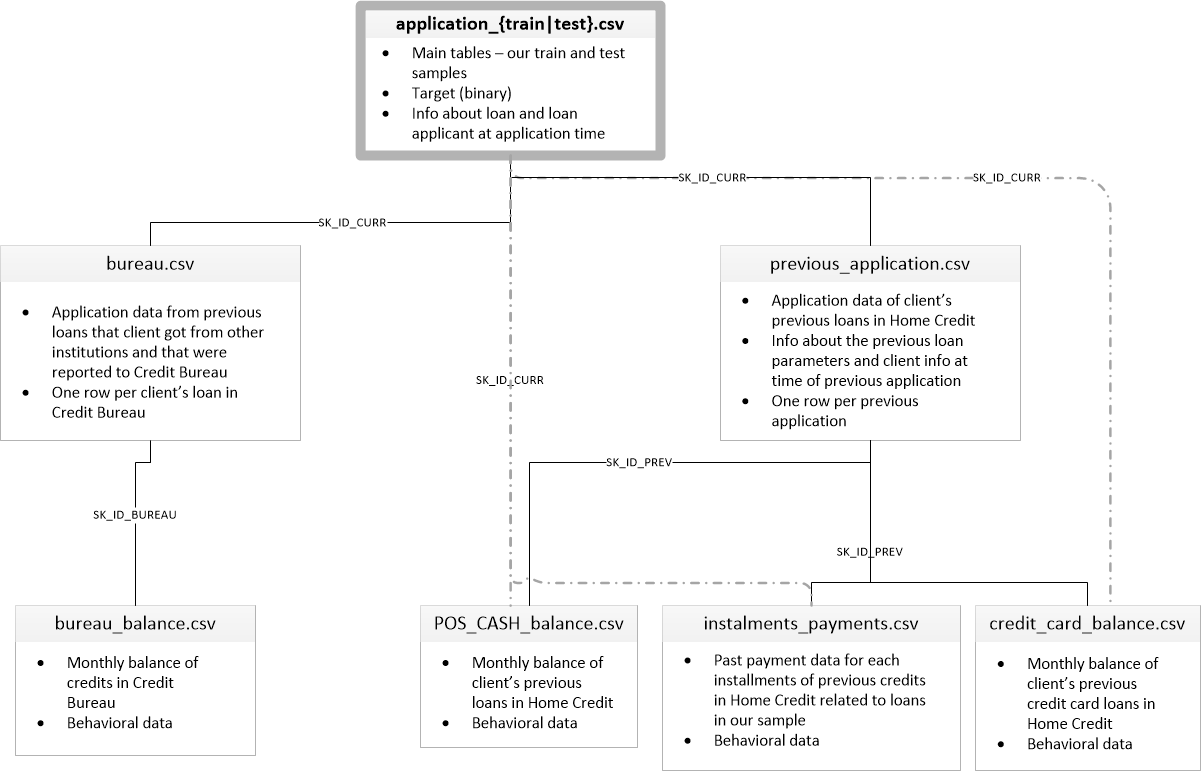

### Feature description
For easier analysis, the feature description might be usefull:

In [ ]:
describtion_df = pd.read_csv(
    "data/HomeCredit_columns_description.csv", encoding="cp1252"
)
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_colwidth", None)  # Show full string in each cell
describtion_df = describtion_df[["Row", "Description"]]

### `application_{train|test}.csv`
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

In [7]:
application_train_df = pd.read_csv("data/application_train.csv")
application_train_df.head(10)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   
5      100008       0         Cash loans           M            N   
6      100009       0         Cash loans           F            Y   
7      100010       0         Cash loans           M            Y   
8      100011       0         Cash loans           F            N   
9      100012       0    Revolving loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   
5               Y             0           99000.0    490495.5      27517.5   
6               Y             1          171000.0   1560726.0      41301.0   
7               Y             0          360000.0   1530000.0      42075.0   
8               Y             0          112500.0   1019610.0      33826.5   
9               Y             0          135000.0    405000.0      20250.0   

   AMT_GOODS_PRICE  NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0         351000.0    Unaccompanied               Working   
1        1129500.0           Family         State servant   
2         135000.0    Unaccompanied               Working   
3         297000.0    Unaccompanied               Working   
4         513000.0    Unaccompanied               Working   
5         454500.0  Spouse, partner         State servant   
6        1395000.0    Unaccompanied  Commercial associate   
7        1530000.0    Unaccompanied         State servant   
8         913500.0         Children             Pensioner   
9         405000.0    Unaccompanied               Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   
5  Secondary / secondary special               Married  House / apartment   
6               Higher education               Married  House / apartment   
7               Higher education               Married  House / apartment   
8  Secondary / secondary special               Married  House / apartment   
9  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   
5                    0.035792      -16941          -1588            -4970.0   
6                    0.035792      -13778          -3130            -1213.0   
7                    0.003122      -18850           -449            -4597.0   
8                    0.018634      -20099         365243            -7427.0   
9                    0.019689      -14469          -2019           -14437.

- `application_train.csv` (train_df) is a main dataset containing the target variable: 1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases.\
For further analysis, for short, we will use different terminology:\
**1 - unsolvent clients (credit applicant)**,\
**0 - solvent clients (credit applicant)**

#### Sanity check

Duplicated detection

In [8]:
application_train_df.duplicated().sum()

0

Transforming XNA on nan
In further analysis 'XNA' values were spotted which probably is a Nan's substitute. Below code, transform XNA on Nan

In [ ]:
application_train_df.replace("XNA", np.nan, inplace=True)

Feature description

In [ ]:
describtion_df[
    describtion_df["Row"].apply(lambda x: x in application_train_df.columns)
]

Row  \
0                      SK_ID_CURR   
1                          TARGET   
2              NAME_CONTRACT_TYPE   
3                     CODE_GENDER   
4                    FLAG_OWN_CAR   
5                 FLAG_OWN_REALTY   
6                    CNT_CHILDREN   
7                AMT_INCOME_TOTAL   
8                      AMT_CREDIT   
9                     AMT_ANNUITY   
10                AMT_GOODS_PRICE   
11                NAME_TYPE_SUITE   
12               NAME_INCOME_TYPE   
13            NAME_EDUCATION_TYPE   
14             NAME_FAMILY_STATUS   
15              NAME_HOUSING_TYPE   
16     REGION_POPULATION_RELATIVE   
17                     DAYS_BIRTH   
18                  DAYS_EMPLOYED   
19              DAYS_REGISTRATION   
20                DAYS_ID_PUBLISH   
21                    OWN_CAR_AGE   
22                     FLAG_MOBIL   
23                 FLAG_EMP_PHONE   
24                FLAG_WORK_PHONE   
25               FLAG_CONT_MOBILE   
26                     FLAG_PHONE   
27                     FLAG_EMAIL   
28                OCCUPATION_TYPE   
29                CNT_FAM_MEMBERS   
30           REGION_RATING_CLIENT   
31    REGION_RATING_CLIENT_W_CITY   
32     WEEKDAY_APPR_PROCESS_START   
33        HOUR_APPR_PROCESS_START   
34     REG_REGION_NOT_LIVE_REGION   
35     REG_REGION_NOT_WORK_REGION   
36    LIVE_REGION_NOT_WORK_REGION   
37         REG_CITY_NOT_LIVE_CITY   
38         REG_CITY_NOT_WORK_CITY   
39        LIVE_CITY_NOT_WORK_CITY   
40              ORGANIZATION_TYPE   
41                   EXT_SOURCE_1   
42                   EXT_SOURCE_2   
43                   EXT_SOURCE_3   
44                 APARTMENTS_AVG   
45               BASEMENTAREA_AVG   
46    YEARS_BEGINEXPLUATATION_AVG   
47                YEARS_BUILD_AVG   
48                 COMMONAREA_AVG   
49                  ELEVATORS_AVG   
50                  ENTRANCES_AVG   
51                  FLOORSMAX_AVG   
52                  FLOORSMIN_AVG   
53                   LANDAREA_AVG   
54           LIVINGAPARTMENTS_AVG   
55                 LIVINGAREA_AVG   
56        NONLIVINGAPARTMENTS_AVG   
57              NONLIVINGAREA_AVG   
58                APARTMENTS_MODE   
59              BASEMENTAREA_MODE   
60   YEARS_BEGINEXPLUATATION_MODE   
61               YEARS_BUILD_MODE   
62                COMMONAREA_MODE   
63                 ELEVATORS_MODE   
64                 ENTRANCES_MODE   
65                 FLOORSMAX_MODE   
66                 FLOORSMIN_MODE   
67                  LANDAREA_MODE   
68          LIVINGAPARTMENTS_MODE   
69                LIVINGAREA_MODE   
70       NONLIVINGAPARTMENTS_MODE   
71             NONLIVINGAREA_MODE   
72                APARTMENTS_MEDI   
73              BASEMENTAREA_MEDI   
74   YEARS_BEGINEXPLUATATION_MEDI   
75               YEARS_BUILD_MEDI   
76                COMMONAREA_MEDI   
77                 ELEVATORS_MEDI   
78                 ENTRANCES_MEDI   
79                 FLOORSMAX_MEDI   
80                 FLOORSMIN_MEDI   
81                  LANDAREA_MEDI   
82          LIVINGAPARTMENTS_MEDI   
83                LIVINGAREA_MEDI   
84       NONLIVINGAPARTMENTS_MEDI   
85             NONLIVINGAREA_MEDI   
86             FONDKAPREMONT_MODE   
87                 HOUSETYPE_MODE   
88                 TOTALAREA_MODE   
89             WALLSMATERIAL_MODE   
90            EMERGENCYSTATE_MODE   
91       OBS_30_CNT_SOCIAL_CIRCLE   
92       DEF_30_CNT_SOCIAL_CIRCLE   
93       OBS_60_CNT_SOCIAL_CIRCLE   
94       DEF_60_CNT_SOCIAL_CIRCLE   
95         DAYS_LAST_PHONE_CHANGE   
96                FLAG_DOCUMENT_2   
97                FLAG_DOCUMENT_3   
98                FLAG_DOCUMENT_4   
99                FLAG_DOCUMENT_5   
100               FLAG_DOCUMENT_6   
101               FLAG_DOCUMENT_7   
102               FLAG_DOCUMENT_8   
103               FLAG_DOCUMENT_9   
104              FLAG_DOCUMENT_10   
105              FLAG_DOCUMENT_11   
106              FLAG_DOCUMENT_12   
107              FLAG_DOCUMENT_13 

- There are variaty of features, both potentially valuable (eg. AMT_CREDIT)  and useless (eg. FLAG_DOCUMENT)
- EXT_SOURCE_1, 2 and 3 are interesting features to focus on

### `bureau.csv`
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [11]:
bureau_df = pd.read_csv("data/bureau.csv")
bureau_df.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

#### Sanity check

Duplicated detection

In [12]:
bureau_df.duplicated().sum()

0

Transforming XNA on nan

In [ ]:
bureau_df.replace("XNA", np.nan, inplace=True)

Feature description

In [14]:
describtion_df[describtion_df["Row"].apply(lambda x: x in bureau_df.columns)]

Row  \
0                SK_ID_CURR   
9               AMT_ANNUITY   
122              SK_ID_CURR   
124           CREDIT_ACTIVE   
125         CREDIT_CURRENCY   
126             DAYS_CREDIT   
127      CREDIT_DAY_OVERDUE   
128     DAYS_CREDIT_ENDDATE   
129       DAYS_ENDDATE_FACT   
130  AMT_CREDIT_MAX_OVERDUE   
131      CNT_CREDIT_PROLONG   
132          AMT_CREDIT_SUM   
133     AMT_CREDIT_SUM_DEBT   
134    AMT_CREDIT_SUM_LIMIT   
135  AMT_CREDIT_SUM_OVERDUE   
136             CREDIT_TYPE   
137      DAYS_CREDIT_UPDATE   
138             AMT_ANNUITY   
143              SK_ID_CURR   
151              SK_ID_CURR   
174              SK_ID_CURR   
176             AMT_ANNUITY   
212              SK_ID_CURR   

                                                                                                             Description  
0                                                                                               ID of loan in our sample  
9                                                                                                           Loan annuity  
122  ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau   
124                                                                    Status of the Credit Bureau (CB) reported credits  
125                                                                         Recoded currency of the Credit Bureau credit  
126                                   How many days before current application did client apply for Credit Bureau credit  
127                       Number of days past due on CB credit at the time of application for related loan in our sample  
128                                  Remaining duration of CB credit (in days) at the time of application in Home Credit  
129                        Days since CB credit ended at the time of application in Home Credit (only for closed credit)  
130                Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)  
131                                                                How many times was the Credit Bureau credit prolonged  
132                                                                   Current credit amount for the Credit Bureau credit  
133                                                                                 Current debt on Credit Bureau credit  
134                                                        Current credit limit of credit card reported in Credit Bureau  
135                                                                       Current amount overdue on Credit Bureau credit  
136                                                                         Type of Credit Bureau credit (Car, cash,...)  
137                       How many days before loan application did last information about the Credit Bureau credit come  
138                                                                                  Annuity of the Credit Bureau credit  
143                                                                                             ID of loan in our sample  
151                                                                                             ID of loan in our sample  
174                                                                                             ID of loan in our sample  
176                                                                                      Annuity of previous application  
212                                                                                             ID of loan in our sample

Subcategories of category features

In [ ]:
print(f"\nUnique categories in categorical features:")
for feature in ["CREDIT_CURRENCY", "CREDIT_TYPE"]:
    print(f"\n'{feature}':")
    print(bureau_df[feature].unique())


Unique categories in categorical features:

'CREDIT_CURRENCY':
['currency 1' 'currency 2' 'currency 4' 'currency 3']

'CREDIT_TYPE':
['Consumer credit' 'Credit card' 'Mortgage' 'Car loan' 'Microloan'
 'Loan for working capital replenishment' 'Loan for business development'
 'Real estate loan' 'Unknown type of loan' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Loan for the purchase of equipment'
 'Mobile operator loan' 'Interbank credit'
 'Loan for purchase of shares (margin lending)']


#### Transforming bureau_df

Convert categorical variable into dummy/indicator variables (0/1) and summing up all features grouped by SK_ID_CURR

In [16]:
bureau_dummy_df = pd.get_dummies(bureau_df, dtype=int)
bureau_dummy_df = (
    bureau_dummy_df.drop(columns=["SK_ID_BUREAU"])
    .groupby(["SK_ID_CURR"])
    .sum()
    .add_prefix("SUM_")
    .add_suffix("_BUREAU")
    .reset_index()
)
bureau_dummy_df.head()

SK_ID_CURR  SUM_DAYS_CREDIT_BUREAU  SUM_CREDIT_DAY_OVERDUE_BUREAU  \
0      100001                   -5145                              0   
1      100002                   -6992                              0   
2      100003                   -5603                              0   
3      100004                   -1734                              0   
4      100005                    -572                              0   

   SUM_DAYS_CREDIT_ENDDATE_BUREAU  SUM_DAYS_ENDDATE_FACT_BUREAU  \
0                           577.0                       -3302.0   
1                         -2094.0                       -4185.0   
2                         -2178.0                       -3292.0   
3                          -977.0                       -1065.0   
4                          1318.0                        -123.0   

   SUM_AMT_CREDIT_MAX_OVERDUE_BUREAU  SUM_CNT_CREDIT_PROLONG_BUREAU  \
0                              0.000                              0   
1                           8405.145                              0   
2                              0.000                              0   
3                              0.000                              0   
4                              0.000                              0   

   SUM_AMT_CREDIT_SUM_BUREAU  SUM_AMT_CREDIT_SUM_DEBT_BUREAU  \
0                1453365.000                        596686.5   
1                 865055.565                        245781.0   
2                1017400.500                             0.0   
3                 189037.800                             0.0   
4                 657126.000                        568408.5   

   SUM_AMT_CREDIT_SUM_LIMIT_BUREAU  SUM_AMT_CREDIT_SUM_OVERDUE_BUREAU  \
0                            0.000                                0.0   
1                        31988.565                                0.0   
2                       810000.000                                0.0   
3                            0.000                                0.0   
4                            0.000                                0.0   

   SUM_DAYS_CREDIT_UPDATE_BUREAU  SUM_AMT_ANNUITY_BUREAU  \
0                           -652                 24817.5   
1                          -3999                     0.0   
2                          -3264                     0.0   
3                          -1064                     0.0   
4                           -163                  4261.5   

   SUM_CREDIT_ACTIVE_Active_BUREAU  SUM_CREDIT_ACTIVE_Bad debt_BUREAU  \
0                                3                                  0   
1                                2                                  0   
2                                1                                  0   
3                                0                                  0   
4                                2                                  0   

   SUM_CREDIT_ACTIVE_Closed_BUREAU  SUM_CREDIT_ACTIVE_Sold_BUREAU  \
0                                4                              0   
1                                6                              0   
2                                3                              0   
3                                2                              0   
4                                1                              0   

   SUM_CREDIT_CURRENCY_currency 1_BUREAU  \
0                                      7   
1                                      8   
2                                      4   
3                                      2   
4                                      3   

   SUM_CREDIT_CURRENCY_currency 2_BUREAU  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   SUM_CREDIT_CURRENCY_currency 3_BUREAU  \
0                                      0   
1                                      0   
2                                      

#### Side questions

What is the distribution of currency among all credits?

Text(0.5, 1.0, 'Count of Credits by Currencies')

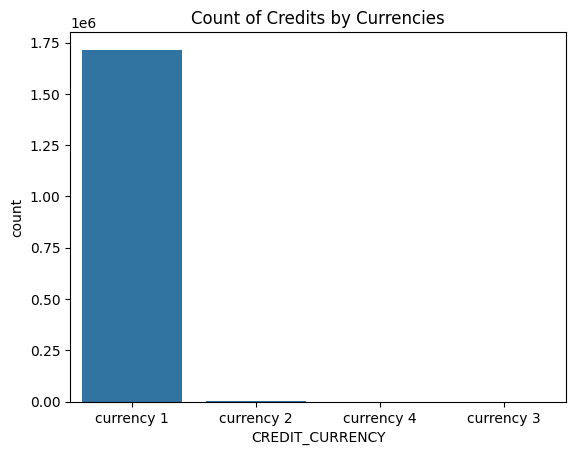

In [17]:
sns.countplot(data=bureau_df, x="CREDIT_CURRENCY")
plt.title("Count of Credits by Currencies")

- The majority of credits are in currency 1

What is the most common credit type?

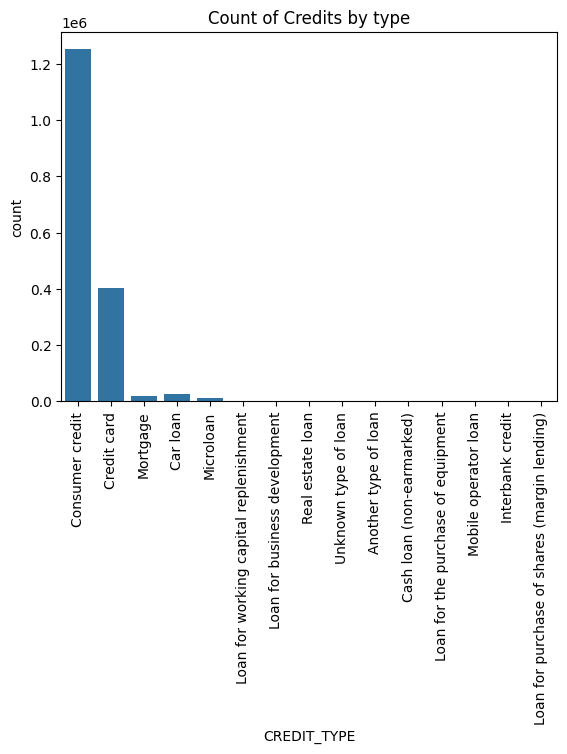

In [ ]:
sns.countplot(data=bureau_df, x="CREDIT_TYPE")
plt.title("Count of Credits by type")
plt.xticks(rotation=90)
plt.show()

- The majority of credits are consumer type and credit cards

### `bureau_balance.csv`
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.


In [19]:
bureau_balance_df = pd.read_csv("data/bureau_balance.csv")
bureau_balance_df.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

#### Sanity check

Duplicated detection

In [20]:
bureau_balance_df.duplicated().sum()

0

Transforming XNA on nan

In [ ]:
bureau_balance_df.replace("XNA", np.nan, inplace=True)

Feature description

In [ ]:
describtion_df[
    describtion_df["Row"].apply(lambda x: x in bureau_balance_df.columns)
]

Row  \
140  MONTHS_BALANCE   
141          STATUS   
144  MONTHS_BALANCE   
152  MONTHS_BALANCE   

                                                                                                                                                                                                                                                        Description  
140                                                                                                                                                                              Month of balance relative to application date (-1 means the freshest balance date)  
141                Status of Credit Bureau loan during the month (active, closed, DPD0-30,… [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off ] )  
144  Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )  
152                                                                                                                                                                              Month of balance relative to application date (-1 means the freshest balance date)

- *bureau_balance* dataset collects logs so for further analysis we can use grouped by *SK_ID_BUREAU* dataset
- This is one of the most importatnt datasets since its bring information about previous debts of the customers and their maximum DPD (stands for **Days Past Due** — a financial term that indicates how many days a loan payment is overdue past its scheduled due date):\
**0**:	No DPD (paid on time)\
**1**:	1–30 days past due\
**2**:	31–60 days past due\
**3**:	61–90 days past due\
**4**:	91–120 days past due\
**5**:	120+ days past due, or sold/written off\
**C**:	Credit closed\
**X**:	No data / status unknown
- Creating new feature: recent DPD event (LAST_STATUS)

#### Transforming bureau_balance_df

Creating new feature using clients' DPD status while applying (LAST_STATUS), suming up all last statuses from multiple credits per client

In [23]:
import duckdb

query = """ 
WITH last_status AS (
    SELECT bureau_df.SK_ID_CURR, LAST_STATUS 
    FROM (SELECT SK_ID_BUREAU, STATUS AS LAST_STATUS 
    FROM bureau_balance_df b
    WHERE MONTHS_BALANCE = (SELECT MAX(MONTHS_BALANCE) FROM bureau_balance_df b2 WHERE b2.SK_ID_BUREAU = b.SK_ID_BUREAU)
    )sub
    JOIN bureau_df ON bureau_df.SK_ID_BUREAU = sub.SK_ID_BUREAU)

SELECT SK_ID_CURR,
    SUM(CASE WHEN LAST_STATUS = '0' THEN 1 ELSE 0 END) AS COUNT_LAST_STATUS_DPD0,
    SUM(CASE WHEN LAST_STATUS = '1' THEN 1 ELSE 0 END) AS COUNT_LAST_STATUS_DPD1,
    SUM(CASE WHEN LAST_STATUS = '2' THEN 1 ELSE 0 END) AS COUNT_LAST_STATUS_DPD2,
    SUM(CASE WHEN LAST_STATUS = '3' THEN 1 ELSE 0 END) AS COUNT_LAST_STATUS_DPD3,
    SUM(CASE WHEN LAST_STATUS = '4' THEN 1 ELSE 0 END) AS COUNT_LAST_STATUS_DPD4,
    SUM(CASE WHEN LAST_STATUS = '5' THEN 1 ELSE 0 END) AS COUNT_LAST_STATUS_DPD5,
    SUM(CASE WHEN LAST_STATUS = 'C' THEN 1 ELSE 0 END) AS COUNT_LAST_STATUS_DPDC,
    SUM(CASE WHEN LAST_STATUS = 'X' THEN 1 ELSE 0 END) AS COUNT_LAST_STATUS_UNKNOWN
FROM last_status
GROUP BY SK_ID_CURR
"""
bureau_balance_trans_df = duckdb.query(query).to_df()
bureau_balance_trans_df.head(5)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

SK_ID_CURR  COUNT_LAST_STATUS_DPD0  COUNT_LAST_STATUS_DPD1  \
0      400434                     0.0                     0.0   
1      357810                     0.0                     0.0   
2      265640                     0.0                     0.0   
3      172684                     0.0                     0.0   
4      192594                     0.0                     0.0   

   COUNT_LAST_STATUS_DPD2  COUNT_LAST_STATUS_DPD3  COUNT_LAST_STATUS_DPD4  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     0.0   

   COUNT_LAST_STATUS_DPD5  COUNT_LAST_STATUS_DPDC  COUNT_LAST_STATUS_UNKNOWN  
0                     0.0                     3.0                        0.0  
1                     0.0                     0.0                        1.0  
2                     0.0                     3.0                        0.0  
3                     0.0                     2.0                        4.0  
4                     0.0                     6.0                        2.0

### `previous_application.csv`
All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

In [24]:
previous_application_df = pd.read_csv("data/previous_application.csv")
previous_application_df.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

#### Sanity check

Duplicated detection

In [25]:
previous_application_df.duplicated().sum()

0

Transforming XNA on nan

In [ ]:
previous_application_df.replace("XNA", np.nan, inplace=True)

Feature description

In [ ]:
describtion_df[
    describtion_df["Row"].apply(lambda x: x in previous_application_df.columns)
]

Row  \
0                     SK_ID_CURR   
2             NAME_CONTRACT_TYPE   
8                     AMT_CREDIT   
9                    AMT_ANNUITY   
10               AMT_GOODS_PRICE   
11               NAME_TYPE_SUITE   
32    WEEKDAY_APPR_PROCESS_START   
33       HOUR_APPR_PROCESS_START   
122                   SK_ID_CURR   
138                  AMT_ANNUITY   
143                   SK_ID_CURR   
147         NAME_CONTRACT_STATUS   
151                   SK_ID_CURR   
170         NAME_CONTRACT_STATUS   
174                   SK_ID_CURR   
175           NAME_CONTRACT_TYPE   
176                  AMT_ANNUITY   
177              AMT_APPLICATION   
178                   AMT_CREDIT   
179             AMT_DOWN_PAYMENT   
180              AMT_GOODS_PRICE   
181   WEEKDAY_APPR_PROCESS_START   
182      HOUR_APPR_PROCESS_START   
183  FLAG_LAST_APPL_PER_CONTRACT   
184       NFLAG_LAST_APPL_IN_DAY   
186            RATE_DOWN_PAYMENT   
187        RATE_INTEREST_PRIMARY   
188     RATE_INTEREST_PRIVILEGED   
189       NAME_CASH_LOAN_PURPOSE   
190         NAME_CONTRACT_STATUS   
191                DAYS_DECISION   
192            NAME_PAYMENT_TYPE   
193           CODE_REJECT_REASON   
194              NAME_TYPE_SUITE   
195             NAME_CLIENT_TYPE   
196          NAME_GOODS_CATEGORY   
197               NAME_PORTFOLIO   
198            NAME_PRODUCT_TYPE   
199                 CHANNEL_TYPE   
200             SELLERPLACE_AREA   
201         NAME_SELLER_INDUSTRY   
202                  CNT_PAYMENT   
203             NAME_YIELD_GROUP   
204          PRODUCT_COMBINATION   
205           DAYS_FIRST_DRAWING   
206               DAYS_FIRST_DUE   
207    DAYS_LAST_DUE_1ST_VERSION   
208                DAYS_LAST_DUE   
209             DAYS_TERMINATION   
210    NFLAG_INSURED_ON_APPROVAL   
212                   SK_ID_CURR   

                                                                                                                                                                                                                                                             Description  
0                                                                                                                                                                                                                                               ID of loan in our sample  
2                                                                                                                                                                                                                            Identification if loan is cash or revolving  
8                                                                                                                                                                                                                                              Credit amount of the loan  
9                                                                                                                                                                                                                                                           Loan annuity  
10                                                                                                                                                                                           For consumer loans it is the price of the goods for which the loan is given  
11                                                                                                                                                                                                         Who was accompanying client when he was applying for the loan  
32                                                                                                                                                                                                            On which day of the week did the client apply for the loan  
33                  

Analysing subcategories in categorical features:

Selecting categorical features

In [28]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

num_cols_previous_app = numerical_columns_selector(previous_application_df)
cat_cols_previous_app = categorical_columns_selector(previous_application_df)

In [29]:
print(f"\nUnique categories in categorical features:")
for feature in cat_cols_previous_app:
    print(f"\n'{feature}':")
    print(previous_application_df[feature].unique())


Unique categories in categorical features:

'NAME_CONTRACT_TYPE':
['Consumer loans' 'Cash loans' 'Revolving loans' nan]

'WEEKDAY_APPR_PROCESS_START':
['SATURDAY' 'THURSDAY' 'TUESDAY' 'MONDAY' 'FRIDAY' 'SUNDAY' 'WEDNESDAY']

'FLAG_LAST_APPL_PER_CONTRACT':
['Y' 'N']

'NAME_CASH_LOAN_PURPOSE':
['XAP' nan 'Repairs' 'Everyday expenses' 'Car repairs'
 'Building a house or an annex' 'Other' 'Journey'
 'Purchase of electronic equipment' 'Medicine' 'Payments on other loans'
 'Urgent needs' 'Buying a used car' 'Buying a new car'
 'Buying a holiday home / land' 'Education' 'Buying a home' 'Furniture'
 'Buying a garage' 'Business development' 'Wedding / gift / holiday'
 'Hobby' 'Gasification / water supply' 'Refusal to name the goal'
 'Money for a third person']

'NAME_CONTRACT_STATUS':
['Approved' 'Refused' 'Canceled' 'Unused offer']

'NAME_PAYMENT_TYPE':
['Cash through the bank' nan 'Non-cash from your account'
 'Cashless from the account of the employer']

'CODE_REJECT_REASON':
['XAP' 'HC' 'L

- There are a lot of categorical columns which might be one-hot encoded
- The features to exclude in the final model might be: 'WEEKDAY_APPR_PROCESS_START'
- 'FLAG_LAST_APPL_PER_CONTRACT' can be transformed on 0 and 1 instead of Y and N

#### Transforming `previous_application_df`

'FLAG_LAST_APPL_PER_CONTRACT' correction

In [ ]:
previous_application_trans_df = previous_application_df.copy()
previous_application_trans_df["FLAG_LAST_APPL_PER_CONTRACT"] = (
    previous_application_trans_df["FLAG_LAST_APPL_PER_CONTRACT"].replace(
        {"Y": 1, "N": 0}
    )
)

Dropping unrelevant features

In [ ]:
previous_application_trans_df.drop(
    columns=[
        "HOUR_APPR_PROCESS_START",
        "WEEKDAY_APPR_PROCESS_START",
        "SELLERPLACE_AREA",
    ],
    inplace=True,
)

Convert categorical variable into dummy/indicator variables (0/1) and summing up all features grouped by SK_ID_CURR

In [32]:
previous_application_trans_dummy_df = pd.get_dummies(
    previous_application_trans_df, dtype=int
)
previous_application_trans_dummy_df = (
    previous_application_trans_dummy_df.drop(columns=["SK_ID_PREV"])
    .groupby(["SK_ID_CURR"])
    .sum()
    .add_prefix("SUM_")
    .add_suffix("_PREV_APP")
    .reset_index()
)
previous_application_trans_dummy_df.head()

SK_ID_CURR  SUM_AMT_ANNUITY_PREV_APP  SUM_AMT_APPLICATION_PREV_APP  \
0      100001                  3951.000                       24835.5   
1      100002                  9251.775                      179055.0   
2      100003                169661.970                     1306309.5   
3      100004                  5357.250                       24282.0   
4      100005                  4813.200                       44617.5   

   SUM_AMT_CREDIT_PREV_APP  SUM_AMT_DOWN_PAYMENT_PREV_APP  \
0                  23787.0                         2520.0   
1                 179055.0                            0.0   
2                1452573.0                         6885.0   
3                  20106.0                         4860.0   
4                  40153.5                         4464.0   

   SUM_AMT_GOODS_PRICE_PREV_APP  SUM_FLAG_LAST_APPL_PER_CONTRACT_PREV_APP  \
0                       24835.5                                         1   
1                      179055.0                                         1   
2                     1306309.5                                         3   
3                       24282.0                                         1   
4                       44617.5                                         2   

   SUM_NFLAG_LAST_APPL_IN_DAY_PREV_APP  SUM_RATE_DOWN_PAYMENT_PREV_APP  \
0                                    1                        0.104326   
1                                    1                        0.000000   
2                                    3                        0.100061   
3                                    1                        0.212008   
4                                    2                        0.108964   

   SUM_RATE_INTEREST_PRIMARY_PREV_APP  SUM_RATE_INTEREST_PRIVILEGED_PREV_APP  \
0                                 0.0                                    0.0   
1                                 0.0                                    0.0   
2                                 0.0                                    0.0   
3                                 0.0                                    0.0   
4                                 0.0                                    0.0   

   SUM_DAYS_DECISION_PREV_APP  SUM_CNT_PAYMENT_PREV_APP  \
0                       -1740                       8.0   
1                        -606                      24.0   
2                       -3915                      30.0   
3                        -815                       4.0   
4                       -1072                      12.0   

   SUM_DAYS_FIRST_DRAWING_PREV_APP  SUM_DAYS_FIRST_DUE_PREV_APP  \
0                         365243.0                      -1709.0   
1                         365243.0                       -565.0   
2                        1095729.0                      -3823.0   
3                         365243.0                       -784.0   
4                         365243.0                       -706.0   

   SUM_DAYS_LAST_DUE_1ST_VERSION_PREV_APP  SUM_DAYS_LAST_DUE_PREV_APP  \
0                                 -1499.0                     -1619.0   
1                                   125.0                       -25.0   
2                                 -3013.0                     -3163.0   
3                                  -694.0                      -724.0   
4                                  -376.0                      -466.0   

   SUM_DAYS_TERMINATION_PREV_APP  SUM_NFLAG_INSURED_ON_APPROVAL_PREV_APP  \
0                        -1612.0                                     0.0   
1                          -17.0                                     0.0   
2                        -3142.0                                     2.0   
3                         -714.0                                     0.0   
4                         -460.0                                     0.0   

   SUM_NAME_CONTRACT_TYPE_Cash loans_PREV_APP  \
0                                           0   
1                                           0   
2      

### `credit_card_balance.csv`
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

In [33]:
credit_card_balance_df = pd.read_csv("data/credit_card_balance.csv")
credit_card_balance_df.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

#### Sanity check

Duplicated detection

In [34]:
credit_card_balance_df.duplicated().sum()

0

Transforming XNA on nan

In [ ]:
credit_card_balance_df.replace("XNA", np.nan, inplace=True)

Feature description

In [ ]:
describtion_df[
    describtion_df["Row"].apply(lambda x: x in credit_card_balance_df.columns)
]

Row  \
0                    SK_ID_CURR   
122                  SK_ID_CURR   
140              MONTHS_BALANCE   
143                  SK_ID_CURR   
144              MONTHS_BALANCE   
147        NAME_CONTRACT_STATUS   
148                      SK_DPD   
149                  SK_DPD_DEF   
151                  SK_ID_CURR   
152              MONTHS_BALANCE   
153                 AMT_BALANCE   
154     AMT_CREDIT_LIMIT_ACTUAL   
155    AMT_DRAWINGS_ATM_CURRENT   
156        AMT_DRAWINGS_CURRENT   
157  AMT_DRAWINGS_OTHER_CURRENT   
158    AMT_DRAWINGS_POS_CURRENT   
159     AMT_INST_MIN_REGULARITY   
160         AMT_PAYMENT_CURRENT   
161   AMT_PAYMENT_TOTAL_CURRENT   
162    AMT_RECEIVABLE_PRINCIPAL   
163               AMT_RECIVABLE   
164        AMT_TOTAL_RECEIVABLE   
165    CNT_DRAWINGS_ATM_CURRENT   
166        CNT_DRAWINGS_CURRENT   
167  CNT_DRAWINGS_OTHER_CURRENT   
168    CNT_DRAWINGS_POS_CURRENT   
169   CNT_INSTALMENT_MATURE_CUM   
170        NAME_CONTRACT_STATUS   
171                      SK_DPD   
172                  SK_DPD_DEF   
174                  SK_ID_CURR   
190        NAME_CONTRACT_STATUS   
212                  SK_ID_CURR   

                                                                                                                                                                                                                                                        Description  
0                                                                                                                                                                                                                                          ID of loan in our sample  
122                                                                                                                                             ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau   
140                                                                                                                                                                              Month of balance relative to application date (-1 means the freshest balance date)  
143                                                                                                                                                                                                                                        ID of loan in our sample  
144  Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )  
147                                                                                                                                                                                                                                Contract status during the month  
148                                                                                                                                                                                                         DPD (days past due) during the month of previous credit  
149                                                                                                                                                            DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit  
151                                                                                                                                                                                                                                        ID of loan in our sample  
152                                                                                                                                                                              Month of balance relative to application

Tracking one of the clients previous credit card balance

In [37]:
query = """ 
SELECT *
FROM credit_card_balance_df
WHERE SK_ID_PREV  = 1969781
ORDER BY MONTHS_BALANCE ASC
"""
duckdb.query(query).to_df()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0      1969781      367965             -96        0.000   
1      1969781      367965             -95    92934.225   
2      1969781      367965             -94   181524.825   
3      1969781      367965             -93   175701.600   
4      1969781      367965             -92   170097.075   
5      1969781      367965             -91   164147.085   
6      1969781      367965             -90   157847.310   
7      1969781      367965             -89   151702.290   
8      1969781      367965             -88   147653.100   
9      1969781      367965             -87   143613.720   
10     1969781      367965             -86   139432.725   
11     1969781      367965             -85   135261.450   
12     1969781      367965             -84   131018.445   
13     1969781      367965             -83   126646.020   
14     1969781      367965             -82   122255.865   
15     1969781      367965             -81   117758.790   
16     1969781      367965             -80   113244.255   
17     1969781      367965             -79   108661.680   
18     1969781      367965             -78   103892.985   
19     1969781      367965             -77   135412.560   
20     1969781      367965             -76   131099.895   
21     1969781      367965             -75   126798.435   
22     1969781      367965             -74   122346.405   
23     1969781      367965             -73   117909.765   
24     1969781      367965             -72   113403.915   
25     1969781      367965             -71   108699.300   
26     1969781      367965             -70   104044.680   
27     1969781      367965             -69    99268.380   
28     1969781      367965             -68    94458.240   
29     1969781      367965             -67   127062.225   
30     1969781      367965             -66   169425.315   
31     1969781      367965             -65   180208.845   
32     1969781      367965             -64   176603.715   
33     1969781      367965             -63   173042.100   
34     1969781      367965             -62   169337.205   
35     1969781      367965             -61   165713.265   
36     1969781      367965             -60   162024.750   
37     1969781      367965             -59   158208.840   
38     1969781      367965             -58   185985.540   
39     1969781      367965             -57   182532.240   
40     1969781      367965             -56   179119.800   
41     1969781      367965             -55   175659.165   
42     1969781      367965             -54   184284.405   
43     1969781      367965             -53   183838.005   
44     1969781      367965             -52   180354.555   
45     1969781      367965             -51   176918.040   
46     1969781      367965             -50   173322.135   
47     1969781      367965             -49   169778.745   
48     1969781      367965             -48   174140.955   
49     1969781      367965             -47   170506.035   
50     1969781      367965             -46   166908.150   
51     1969781      367965             -45   163165.950   
52     1969781      367965             -44   159452.370   
53     1969781      367965             -43   179448.075   
54     1969781      367965             -42   175723.380   
55     1969781      367965             -41   186445.890   
56     1969781      367965             -40   183006.270   
57     1969781      367965             -39   179613.945   
58     1969781      367965             -38   176072.310   
59     1969781      367965             -37   182759.985   
60     1969781      367965             -36   179341.065   
61     1969781      367965             -35   175790.025   
62     1969781      367965             -34   172261.935   
63     1969781      367965             -33   168604.695   
64     1969781      367965             -32   181996.875   
65     1969781      367965             -31   183312.765   
66     1969781      367965             -30   186276

- Analyzing one of the clients previous credit card balance, we can filter the most important feature to grouped by SK_ID_PREV:
    - AMT_BALANCE on last status (last months balance before application)
    - NAME_CONTRACT_STATUS on last status (last months balance)
    - the rest of the values will be summed, counted or averaged

#### Transforming credit_card_balance_df
Selecting contract status during application day per credit for all clients

In [38]:
query = """ 
WITH last_status AS(
    SELECT SK_ID_PREV, NAME_CONTRACT_STATUS AS LAST_NAME_CONTRACT_STATUS, AMT_BALANCE AS LAST_AMT_BALANCE
    FROM credit_card_balance_df c
    WHERE MONTHS_BALANCE = (SELECT MAX(MONTHS_BALANCE) FROM credit_card_balance_df c2 WHERE c2.SK_ID_PREV = c.SK_ID_PREV)),
balance AS(
    SELECT 
        SK_ID_PREV, 
        SK_ID_CURR,
        AVG(AMT_CREDIT_LIMIT_ACTUAL) AS AVG_AMT_CREDIT_LIMIT_ACTUAL,
        SUM(AMT_DRAWINGS_ATM_CURRENT) AS SUM_AMT_DRAWINGS_ATM_CURRENT,
        SUM(AMT_DRAWINGS_CURRENT) AS SUM_AMT_DRAWINGS_CURRENT,
        SUM(AMT_DRAWINGS_OTHER_CURRENT) AS SUM_AMT_DRAWINGS_OTHER_CURRENT,
        SUM(AMT_DRAWINGS_POS_CURRENT) AS SUM_AMT_DRAWINGS_POS_CURRENT,
        SUM(AMT_INST_MIN_REGULARITY) AS SUM_AMT_INST_MIN_REGULARITY,
        SUM(AMT_PAYMENT_CURRENT) AS SUM_AMT_PAYMENT_CURRENT,
        SUM(AMT_PAYMENT_TOTAL_CURRENT) AS SUM_AMT_PAYMENT_TOTAL_CURRENT,
        SUM(AMT_RECEIVABLE_PRINCIPAL) AS SUM_AMT_RECEIVABLE_PRINCIPAL,
        SUM(AMT_RECIVABLE) AS SUM_AMT_RECEIVABLE,
        SUM(AMT_TOTAL_RECEIVABLE) AS SUM_AMT_TOTAL_RECEIVABLE,
        SUM(CNT_DRAWINGS_ATM_CURRENT) AS SUM_CNT_DRAWINGS_ATM_CURRENT,
        SUM(CNT_DRAWINGS_CURRENT) AS SUM_CNT_DRAWINGS_CURRENT,
        SUM(CNT_DRAWINGS_OTHER_CURRENT) AS SUM_CNT_DRAWINGS_OTHER_CURRENT,
        SUM(CNT_DRAWINGS_POS_CURRENT) AS SUM_CNT_DRAWINGS_POS_CURRENT,
        SUM(CNT_INSTALMENT_MATURE_CUM) AS SUM_CNT_INSTALMENT_MATURE_CUM,
        SUM(SK_DPD) AS SUM_SK_DPD,
        SUM(SK_DPD_DEF) AS SUM_SK_DPD_DEF
    FROM credit_card_balance_df
    GROUP BY SK_ID_CURR, SK_ID_PREV
)

SELECT *
FROM balance
JOIN last_status ON last_status.SK_ID_PREV = balance.SK_ID_PREV
"""
credit_card_balance_trans_df = duckdb.query(query).to_df()
credit_card_balance_trans_df.head(5)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

SK_ID_PREV  SK_ID_CURR  AVG_AMT_CREDIT_LIMIT_ACTUAL  \
0     2350184      410566                135000.000000   
1     1264712      374177                 44052.631579   
2     1304948      331604                 80156.250000   
3     2812924      296845                159084.507042   
4     1810954      108903                136901.408451   

   SUM_AMT_DRAWINGS_ATM_CURRENT  SUM_AMT_DRAWINGS_CURRENT  \
0                      123300.0                123300.000   
1                      198000.0                198000.000   
2                       36450.0                 36450.000   
3                      284625.0                446366.205   
4                       90000.0                 90000.000   

   SUM_AMT_DRAWINGS_OTHER_CURRENT  SUM_AMT_DRAWINGS_POS_CURRENT  \
0                             0.0                         0.000   
1                             0.0                         0.000   
2                             0.0                         0.000   
3                        140868.0                     20873.205   
4                             0.0                         0.000   

   SUM_AMT_INST_MIN_REGULARITY  SUM_AMT_PAYMENT_CURRENT  \
0                   344595.870               376213.005   
1                   141910.380               344011.590   
2                   232641.990               269587.440   
3                   495732.285               762775.920   
4                    39419.280               109409.040   

   SUM_AMT_PAYMENT_TOTAL_CURRENT  SUM_AMT_RECEIVABLE_PRINCIPAL  \
0                      375101.73                   4761076.545   
1                      335070.00                   1757574.720   
2                      248400.00                   2989202.535   
3                      759240.00                   5238723.960   
4                      106956.54                     84035.160   

   SUM_AMT_RECEIVABLE  SUM_AMT_TOTAL_RECEIVABLE  SUM_CNT_DRAWINGS_ATM_CURRENT  \
0         4961511.630               4961511.630                          11.0   
1         1836595.035               1840375.035                           7.0   
2         3125909.520               3125909.520                          11.0   
3         5644370.430               5644370.430                          61.0   
4          104193.765                104193.765                           3.0   

   SUM_CNT_DRAWINGS_CURRENT  SUM_CNT_DRAWINGS_OTHER_CURRENT  \
0                      11.0                             0.0   
1                       7.0                             0.0   
2                      11.0                             0.0   
3                      87.0                            14.0   
4                       3.0                             0.0   

   SUM_CNT_DRAWINGS_POS_CURRENT  SUM_CNT_INSTALMENT_MATURE_CUM  SUM_SK_DPD  \
0                           0.0                         4164.0         7.0   
1                           0.0                         2049.0         3.0   
2                           0.0                         4674.0        17.0   
3                          12.0                         2340.0         0.0   
4                           0.0                          758.0     20314.0   

   SUM_SK_DPD_DEF  SK_ID_PREV_1 LAST_NAME_CONTRACT_STATUS  LAST_AMT_BALANCE  
0             7.0       2350184                 Completed             0.000  
1             3.0       1264712                    Active             0.000  
2            17.0       1304948                    Active             0.000  
3             0.0       2812924                    Active         48325.815  
4             3.0       1810954                    Active             0.000

Summing all features per credit applicant (grouped by SK_ID_CURR)

In [ ]:
credit_card_balance_trans_dummy_df = pd.get_dummies(
    credit_card_balance_trans_df, dtype=int
)
credit_card_balance_trans_dummy_df = (
    credit_card_balance_trans_dummy_df.drop(columns=["SK_ID_PREV"])
    .groupby(["SK_ID_CURR"])
    .sum()
    .add_prefix("SUM_")
    .add_suffix("_CRED_CARD")
    .reset_index()
)
credit_card_balance_trans_dummy_df.head()

SK_ID_CURR  SUM_AVG_AMT_CREDIT_LIMIT_ACTUAL_CRED_CARD  \
0      100006                              270000.000000   
1      100011                              164189.189189   
2      100013                              131718.750000   
3      100021                              675000.000000   
4      100023                              135000.000000   

   SUM_SUM_AMT_DRAWINGS_ATM_CURRENT_CRED_CARD  \
0                                         0.0   
1                                    180000.0   
2                                    571500.0   
3                                         0.0   
4                                         0.0   

   SUM_SUM_AMT_DRAWINGS_CURRENT_CRED_CARD  \
0                                     0.0   
1                                180000.0   
2                                571500.0   
3                                     0.0   
4                                     0.0   

   SUM_SUM_AMT_DRAWINGS_OTHER_CURRENT_CRED_CARD  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   SUM_SUM_AMT_DRAWINGS_POS_CURRENT_CRED_CARD  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   SUM_SUM_AMT_INST_MIN_REGULARITY_CRED_CARD  \
0                                      0.000   
1                                 288804.195   
2                                 129454.020   
3                                      0.000   
4                                      0.000   

   SUM_SUM_AMT_PAYMENT_CURRENT_CRED_CARD  \
0                                   0.00   
1                              358386.75   
2                              688161.24   
3                                   0.00   
4                                   0.00   

   SUM_SUM_AMT_PAYMENT_TOTAL_CURRENT_CRED_CARD  \
0                                        0.000   
1                                   334485.000   
2                                   654448.545   
3                                        0.000   
4                                        0.000   

   SUM_SUM_AMT_RECEIVABLE_PRINCIPAL_CRED_CARD  \
0                                       0.000   
1                                 3877754.580   
2                                 1656533.745   
3                                       0.000   
4                                       0.000   

   SUM_SUM_AMT_RECEIVABLE_CRED_CARD  SUM_SUM_AMT_TOTAL_RECEIVABLE_CRED_CARD  \
0                             0.000                                   0.000   
1                       4028055.255                             4028055.255   
2                       1737703.665                             1737703.665   
3                             0.000                                   0.000   
4                             0.000                                   0.000   

   SUM_SUM_CNT_DRAWINGS_ATM_CURRENT_CRED_CARD  \
0                                         0.0   
1                                         4.0   
2                                        23.0   
3                                         0.0   
4                                         0.0   

   SUM_SUM_CNT_DRAWINGS_CURRENT_CRED_CARD  \
0                                     0.0   
1                                     4.0   
2                                    23.0   
3                                     0.0   
4                                     0.0   

   SUM_SUM_CNT_DRAWINGS_OTHER_CURRENT_CRED_CARD  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                           

### `installments_payments.csv`
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [40]:
installments_payments_df = pd.read_csv("data/installments_payments.csv")
installments_payments_df.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

#### Sanity check

Duplicated detection

In [41]:
installments_payments_df.duplicated().sum()

0

Transforming XNA on nan

In [ ]:
installments_payments_df.replace("XNA", np.nan, inplace=True)

Feature description

In [ ]:
describtion_df[
    describtion_df["Row"].apply(
        lambda x: x in installments_payments_df.columns
    )
]

Row  \
0                SK_ID_CURR   
122              SK_ID_CURR   
143              SK_ID_CURR   
151              SK_ID_CURR   
174              SK_ID_CURR   
212              SK_ID_CURR   
213  NUM_INSTALMENT_VERSION   
214   NUM_INSTALMENT_NUMBER   
215         DAYS_INSTALMENT   
216      DAYS_ENTRY_PAYMENT   
217          AMT_INSTALMENT   
218             AMT_PAYMENT   

                                                                                                                                                                                    Description  
0                                                                                                                                                                      ID of loan in our sample  
122                                                                         ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau   
143                                                                                                                                                                    ID of loan in our sample  
151                                                                                                                                                                    ID of loan in our sample  
174                                                                                                                                                                    ID of loan in our sample  
212                                                                                                                                                                    ID of loan in our sample  
213  Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed  
214                                                                                                                                                     On which installment we observe payment  
215                                                                              When the installment of previous credit was supposed to be paid (relative to application date of current loan)  
216                                                                                   When was the installments of previous credit paid actually (relative to application date of current loan)  
217                                                                                                           What was the prescribed installment amount of previous credit on this installment  
218                                                                                                                        What the client actually paid on previous credit on this installment

- This dataset is another LOG book with monthly payments info
- For better insights, for each customer ID, instalment delay and differences in installemet and the money actually paid, can be calculated.

#### Transforming installments_payments

Calculating instalment payment delays (COUNT_LATE_PAYMENT) and difference in installement amount payed (COUNT_UNSUFFICIENT_PAYMENT) per client

In [44]:
query = """ 
SELECT SK_ID_CURR, 
    SUM(LATE_PAYMENT) AS COUNT_LATE_PAYMENT,
    SUM(INSUFFICIENT_PAYMENT) AS COUNT_INSUFFICIENT_PAYMENT
FROM (
    SELECT
        SK_ID_PREV, SK_ID_CURR,
        CASE WHEN (DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT) <= 0 THEN 0 ELSE 1 END AS LATE_PAYMENT,
        CASE WHEN (AMT_PAYMENT - AMT_INSTALMENT) >= 0 THEN 0 ELSE 1 END AS INSUFFICIENT_PAYMENT
    FROM installments_payments_df
    ) sub
GROUP BY SK_ID_CURR
	
"""
installments_payments_trans_df = duckdb.query(query).to_df()
installments_payments_trans_df.head(5)

SK_ID_CURR  COUNT_LATE_PAYMENT  COUNT_INSUFFICIENT_PAYMENT
0      109373                 0.0                         0.0
1      100383                 3.0                         4.0
2      143759                10.0                        16.0
3      154000                 6.0                         6.0
4      153033                 0.0                         2.0

### `POS_CASH_balance.csv`
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

In [45]:
pos_cash_balance_df = pd.read_csv("data/POS_CASH_balance.csv")
pos_cash_balance_df.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

#### Sanity check

Duplicated detection

In [46]:
pos_cash_balance_df.duplicated().sum()

0

Transforming XNA on nan

In [ ]:
pos_cash_balance_df.replace("XNA", np.nan, inplace=True)

Feature description

In [ ]:
describtion_df[
    describtion_df["Row"].apply(lambda x: x in pos_cash_balance_df.columns)
]

Row  \
0               SK_ID_CURR   
122             SK_ID_CURR   
140         MONTHS_BALANCE   
143             SK_ID_CURR   
144         MONTHS_BALANCE   
145         CNT_INSTALMENT   
146  CNT_INSTALMENT_FUTURE   
147   NAME_CONTRACT_STATUS   
148                 SK_DPD   
149             SK_DPD_DEF   
151             SK_ID_CURR   
152         MONTHS_BALANCE   
170   NAME_CONTRACT_STATUS   
171                 SK_DPD   
172             SK_DPD_DEF   
174             SK_ID_CURR   
190   NAME_CONTRACT_STATUS   
212             SK_ID_CURR   

                                                                                                                                                                                                                                                        Description  
0                                                                                                                                                                                                                                          ID of loan in our sample  
122                                                                                                                                             ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau   
140                                                                                                                                                                              Month of balance relative to application date (-1 means the freshest balance date)  
143                                                                                                                                                                                                                                        ID of loan in our sample  
144  Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )  
145                                                                                                                                                                                                                  Term of previous credit (can change over time)  
146                                                                                                                                                                                                                 Installments left to pay on the previous credit  
147                                                                                                                                                                                                                                Contract status during the month  
148                                                                                                                                                                                                         DPD (days past due) during the month of previous credit  
149                                                                                                                                                            DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit  
151                                                                                                                                                                                                                                        ID of loan in our sample  
152                                                                                                                                                                              Month of balance relative to application date (-1 means the freshest balance date)  
170                                           

- Here once again we will focus NAME_CONTRACT_STATUS on the last months_balance and we will count SK_DPD and SK_DPD_DEF for every client

#### Transforming `pos_cash_balance_df`

Creating LAST_NAME_CONTRACT_STATUS_POS_CASH feature (contract status while applying) and summing up days past due (SK_DPD and SK_DPD_DEF) per previous credit application (SK_ID_PREV)

In [49]:
query = """ 
WITH last_status AS(
    SELECT SK_ID_PREV, NAME_CONTRACT_STATUS AS LAST_NAME_CONTRACT_STATUS_POS_CASH
    FROM pos_cash_balance_df p
    WHERE MONTHS_BALANCE = (SELECT MAX(MONTHS_BALANCE) FROM pos_cash_balance_df p2 WHERE p2.SK_ID_PREV = p.SK_ID_PREV)),
balance AS(
    SELECT 
        SK_ID_PREV, 
        SK_ID_CURR,
        SUM(SK_DPD) AS SUM_SK_DPD_POS_CASH,
        SUM(SK_DPD_DEF) AS SUM_SK_DPD_DEF_POS_CASH
    FROM pos_cash_balance_df
    GROUP BY SK_ID_CURR, SK_ID_PREV
)

SELECT *
FROM balance
JOIN last_status ON last_status.SK_ID_PREV = balance.SK_ID_PREV
"""
pos_cash_balance_trans_df = duckdb.query(query).to_df()
pos_cash_balance_trans_df.head(5)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

SK_ID_PREV  SK_ID_CURR  SUM_SK_DPD_POS_CASH  SUM_SK_DPD_DEF_POS_CASH  \
0     1829607      105626                  0.0                      0.0   
1     2706129      392391                 32.0                      2.0   
2     2287694      132064                  0.0                      0.0   
3     1678579      140000                  0.0                      0.0   
4     2643186      270677                  0.0                      0.0   

   SK_ID_PREV_1 LAST_NAME_CONTRACT_STATUS_POS_CASH  
0       1829607                             Active  
1       2706129                          Completed  
2       2287694                             Active  
3       1678579                          Completed  
4       2643186                             Active

Summing up features per current client (SK_ID_CURR) 

In [50]:
query = """ 
SELECT
    SK_ID_CURR,
    SUM(CASE WHEN LAST_NAME_CONTRACT_STATUS_POS_CASH = 'Active' THEN 1 ELSE 0 END) AS COUNT_LAST_ACTIVE_CONTRACT_STATUS_POS_CASH,
    SUM(CASE WHEN LAST_NAME_CONTRACT_STATUS_POS_CASH = 'Completed' THEN 1 ELSE 0 END) AS COUNT_LAST_COMPLETED_CONTRACT_STATUS_POS_CASH,
    SUM(SUM_SK_DPD_POS_CASH) AS SUM_SK_DPD_POS_CASH,
    SUM(SUM_SK_DPD_DEF_POS_CASH) AS SUM_SK_DPD_DEF_POS_CASH,
FROM pos_cash_balance_trans_df
GROUP BY SK_ID_CURR
"""
pos_cash_balance_trans_df = duckdb.query(query).to_df()
pos_cash_balance_trans_df.head(5)

SK_ID_CURR  COUNT_LAST_ACTIVE_CONTRACT_STATUS_POS_CASH  \
0      190690                                         1.0   
1      246343                                         2.0   
2      357573                                         1.0   
3      411915                                         2.0   
4      406609                                         2.0   

   COUNT_LAST_COMPLETED_CONTRACT_STATUS_POS_CASH  SUM_SK_DPD_POS_CASH  \
0                                            1.0                  0.0   
1                                            6.0                 11.0   
2                                            4.0                  0.0   
3                                            9.0                  1.0   
4                                            3.0                  0.0   

   SUM_SK_DPD_DEF_POS_CASH  
0                      0.0  
1                      0.0  
2                      0.0  
3                      1.0  
4                      0.0

### `joined_df`
Joining all datasets together by applicant (SK_ID_CURR)

#### With application_train_df

In [ ]:
query = """ 
SELECT  *

FROM application_train_df app

LEFT JOIN buream, USING(SK_ID_CURR)
LEFT JOIN bureau_dummy_df bd USING(SK_ID_CURR)
LEFT JOIN credit_card_balance_trans_dummy_df ccb USING(SK_ID_CURR)
LEFT JOIN previous_application_trans_dummy_df USING(SK_ID_CURR)
LEFT JOIN pos_cash_balance_trans_df USING(SK_ID_CURR)
LEFT JOIN installments_payments_trans_df USING(SK_ID_CURR)
"""
joined_df = duckdb.query(query).to_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

#### With application_test_df

For future kaggle submission, same procedure will be made with application_test_df

In [52]:
application_test_df = pd.read_csv("data/application_test.csv")

In [ ]:
query = """ 
SELECT  *

FROM application_test_df app

LEFT JOIN bureau_balance_trans_df USING(SK_ID_CURR)
LEFT JOIN bureau_dummy_df bd USING(SK_ID_CURR)
LEFT JOIN credit_card_balance_trans_dummy_df ccb USING(SK_ID_CURR)
LEFT JOIN previous_application_trans_dummy_df USING(SK_ID_CURR)
LEFT JOIN pos_cash_balance_trans_df USING(SK_ID_CURR)
LEFT JOIN installments_payments_trans_df ON installments_payments_trans_df.SK_ID_CURR = app.SK_ID_CURR
"""
joined_test_df = duckdb.query(query).to_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Sample of joined_df

In [54]:
joined_df.head(5)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      455911       0         Cash loans           F            N   
1      455912       0         Cash loans           F            N   
2      455917       0    Revolving loans           F            N   
3      455918       0    Revolving loans           F            N   
4      455919       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          112500.0    536917.5      19413.0   
1               Y             0          108000.0    291384.0      20853.0   
2               Y             0          180000.0    270000.0      13500.0   
3               Y             0           72000.0    157500.0       7875.0   
4               N             0           76500.0    448056.0      16092.0   

   AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0         463500.0   Unaccompanied               Working   
1         270000.0          Family               Working   
2         270000.0   Unaccompanied               Working   
3         157500.0   Unaccompanied  Commercial associate   
4         315000.0          Family             Pensioner   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special             Separated  House / apartment   
1               Higher education                 Widow  House / apartment   
2  Secondary / secondary special               Married  House / apartment   
3               Higher education  Single / not married  House / apartment   
4  Secondary / secondary special                 Widow  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.010147      -19746          -4093            -8884.0   
1                    0.030755      -23278          -7289             -124.0   
2                    0.035792      -19917          -3810            -6909.0   
3                    0.003122      -10668           -950            -2970.0   
4                    0.022800      -22723         365243            -4840.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -3287          NaN           1               1                0   
1            -4560          NaN           1               1                0   
2            -3406          NaN           1               1                0   
3            -2415          NaN           1               1                0   
4            -4095          NaN           1               0                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           0           0            None              1.0   
1                 1           0           0        Managers              1.0   
2                 1           0           0     Sales staff              2.0   
3                 1           0           1  Medicine staff              1.0   
4                 1           1           0            None              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     2                            2   
2                     2                            2   
3                     3                            3   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                     FRIDAY                       10   
1                     MONDAY                       14   
2                  WEDNESDAY                       15   
3                   THURSDAY                       16   
4                  WEDNESDAY                       17   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           

#### Sanity check

`joined_df` details

In [55]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 337 entries, SK_ID_CURR to COUNT_INSUFFICIENT_PAYMENT
dtypes: float64(280), int64(41), object(16)
memory usage: 790.6+ MB


- 337 feature

New joined_df should have same lenght as application_train_df

In [56]:
len(joined_df) == len(application_train_df)

True

Checking if there are any duplicates

In [57]:
joined_df.duplicated().sum()

0

#### Feature selection
The most important features will be selected using model.feature_importances_ calculated with LightGBMClassifier. This model was chosen due to its, efficiency, missing value auto-handling and high interpretability. Automatic missing value auto-handling was chosen due to the important information that it may carry. The model should take them into account.

Transforming column names replacing special characters and whitespaces

In [ ]:
joined_df.columns = joined_df.columns.str.replace(
    r"[^a-zA-Z0-9_]", "_", regex=True
)

Creating list of selected features using 30 feature importance threshold (subjective - point of sudden importance decrease)

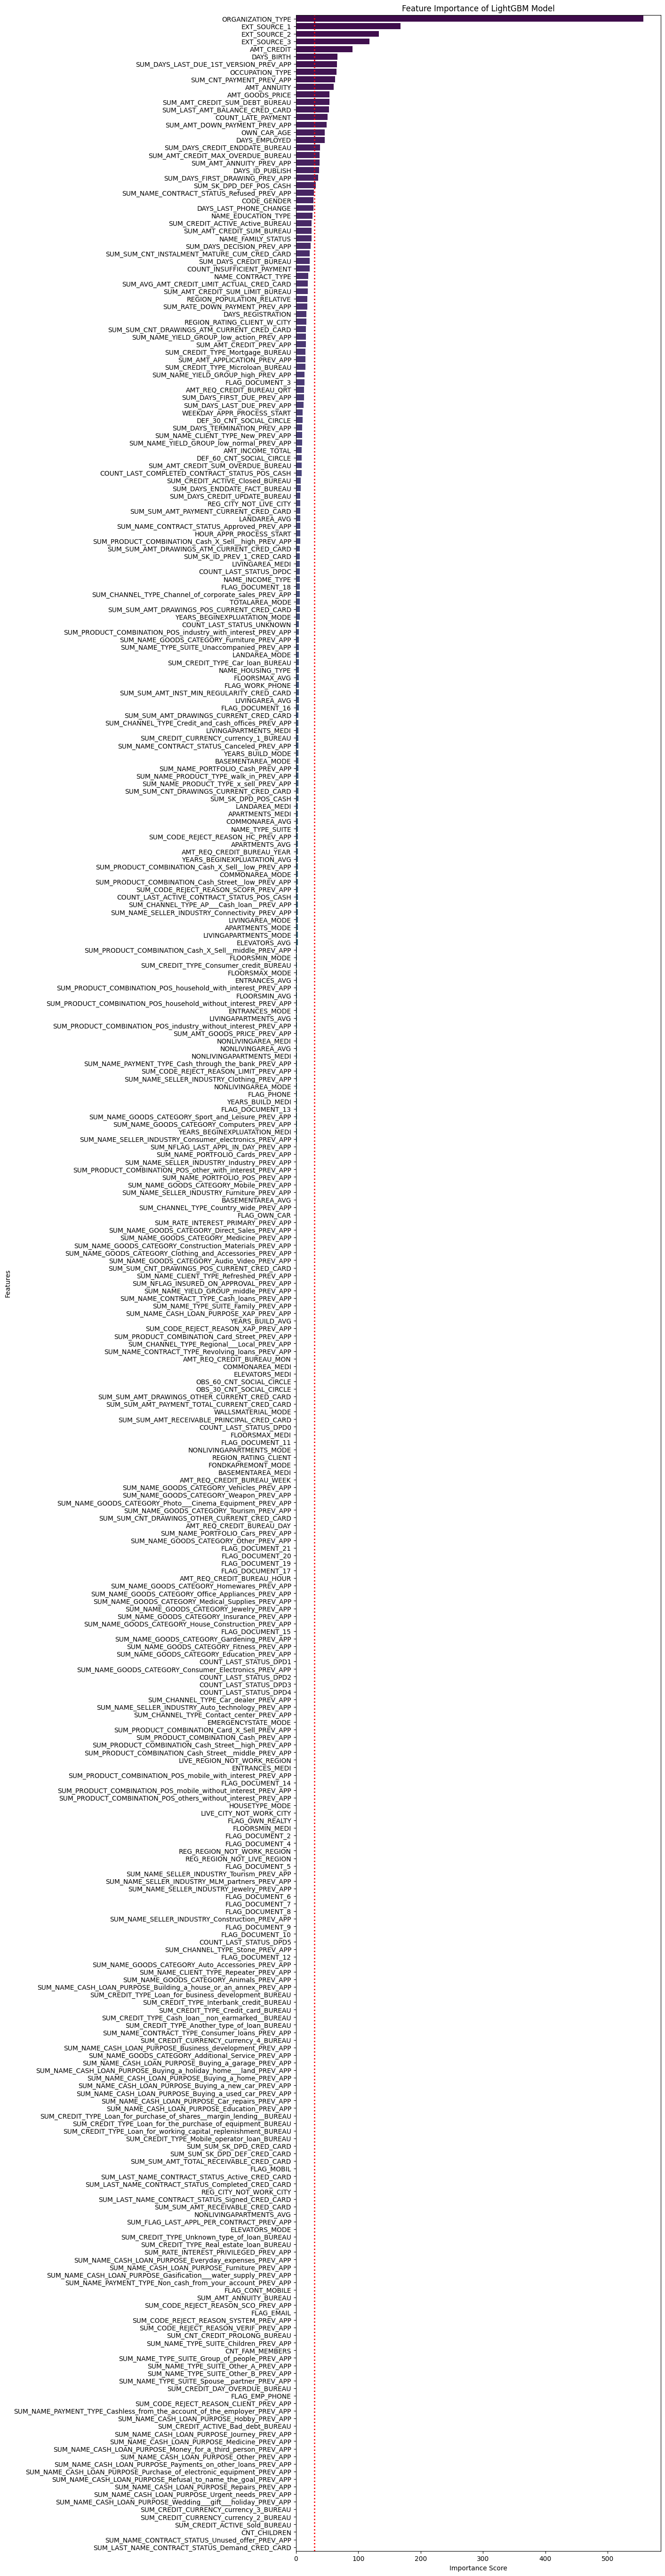

In [ ]:
def feature_selection(df, threshold):
    """Selects the most informative features from the dataframe using feature importance threshold with set value. Shows barplots of all features with descending feature importance. Feature importance calculated using LightGBM model.
    :param df: dataframe to analyse with TARGET
    :type df: DataFrame
    :param threshold: feature importance score threshold on which features will be selected (features above threshold)
    :type threshold: int
    :return: list of selected features from dataframe
    :rtype: list
    """
    y = df["TARGET"]
    X = df.drop(columns=["TARGET", "SK_ID_CURR"])

    # Changing type of categorical feature on 'category'
    for col in X.select_dtypes(include="object").columns:
        X[col] = X[col].astype("category")

    # Creating a feature importatnt scores using LightGBM
    model = lgb.LGBMClassifier(
        class_weight="balanced", random_state=0, verbose=-1
    )
    model.fit(X, y)
    importances = model.feature_importances_

    importance_df = pd.DataFrame(
        {"Feature": X.columns, "Importance": importances}
    ).sort_values(by="Importance", ascending=False)

    # Plotting the feature importance scores with the threshold subjectivly setted
    plt.figure(figsize=(10, 70))
    sns.barplot(
        data=importance_df, x="Importance", y="Feature", palette="viridis"
    )

    plt.axvline(x=threshold, color="red", linestyle="dotted", linewidth=2)
    plt.title("Feature Importance of LightGBM Model")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()

    feat_selected_list = importance_df[
        importance_df["Importance"] > threshold
    ]["Feature"].to_list()

    return feat_selected_list


feat_selected_list = feature_selection(joined_df, 30)

- Interestingly, the most informative feature is ORGANIZATION_TYPE
- On the top are also EXT_SOURCE 1, 2 and 3 - client credit score from external source
- From 331 features, 23 was arbitrary selected

#### `joined_df` details

How many features were selected?

In [96]:
len(feat_selected_list)

23

Creating a final dataframe for part II

In [ ]:
final_df = joined_df[feat_selected_list + ["TARGET"]]
final_kaggle_test_df = joined_test_df[feat_selected_list + ["SK_ID_CURR"]]

Storing final_df and joined_df for easier handling during part II

In [100]:
%store final_df joined_df final_kaggle_test_df

Stored 'final_df' (DataFrame)
Stored 'joined_df' (DataFrame)
Stored 'final_kaggle_test_df' (DataFrame)


#### Missing values

In [101]:
num_rows_with_nans = final_df.isnull().any(axis=1).sum()
print(f"Number of rows with NaNs: {num_rows_with_nans}")

Number of rows with NaNs: 298299


Visualising missing values in final_df

<Figure size 800x500 with 0 Axes>

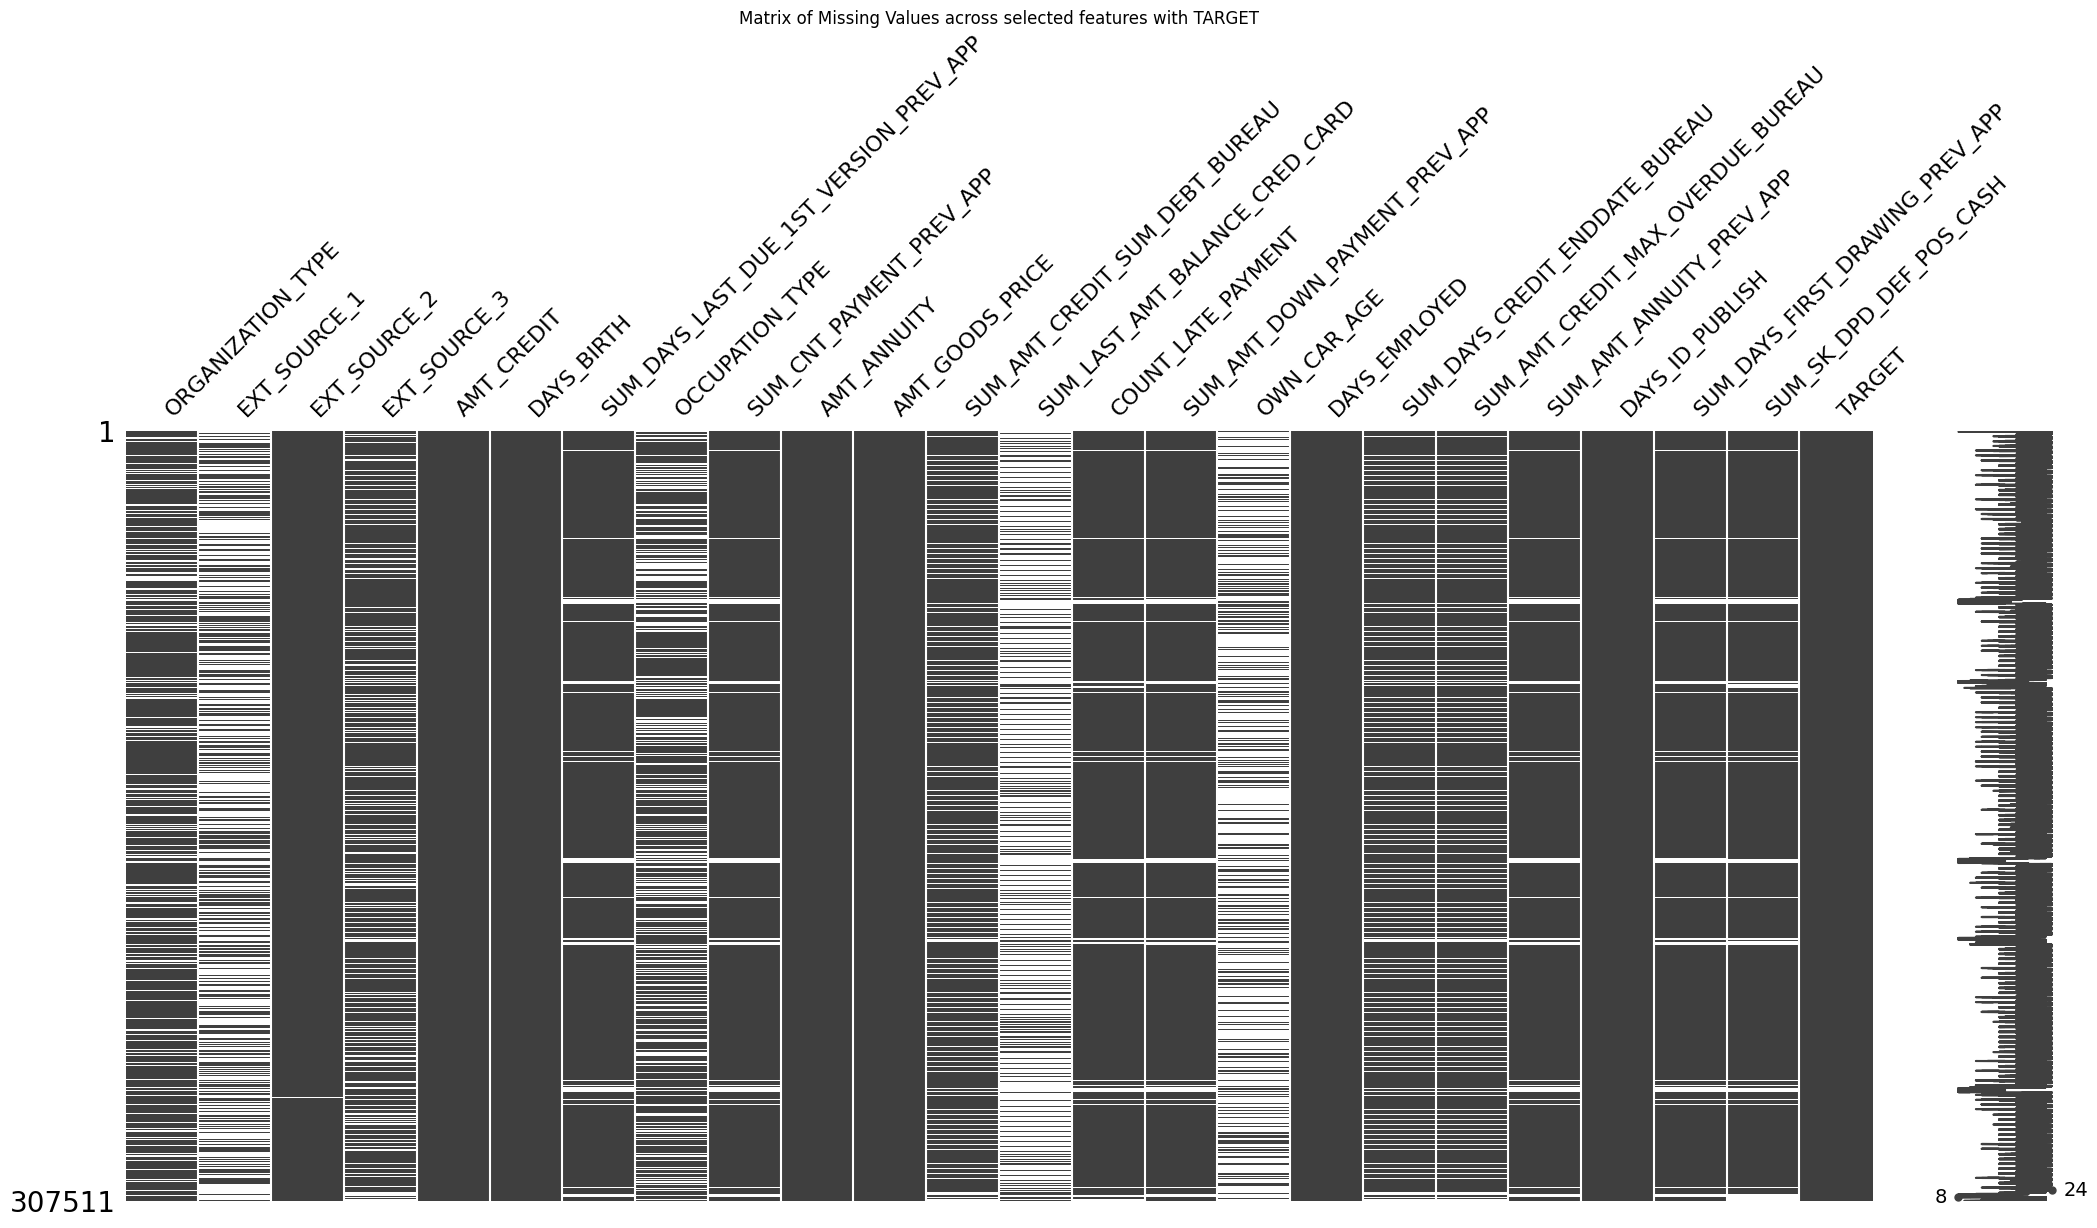

In [ ]:
import missingno as msno

plt.figure(figsize=(8, 5))
msno.matrix(final_df)
plt.title("Matrix of Missing Values across selected features with TARGET")

- There are some patterns of missing values among samples which are most likely due to te fact that some clients eg. have never applied for the credit before so they will have missing value in all *_PREV_APP features 

#### Analysis Report
Analysis Report from selected features will be created using sweetviz mudule

**The report can be found in files `final_df_analysis_report.html`**

                                             |          | [  0%]   00:00 -> (? left)


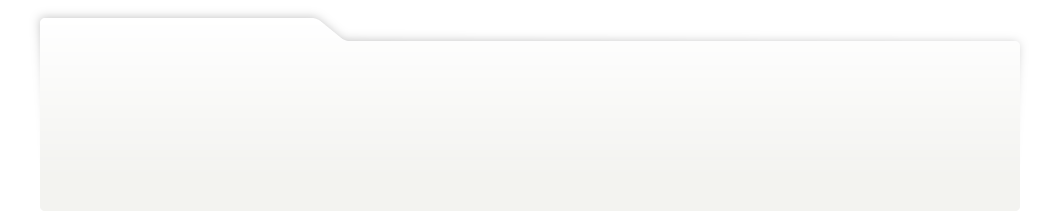
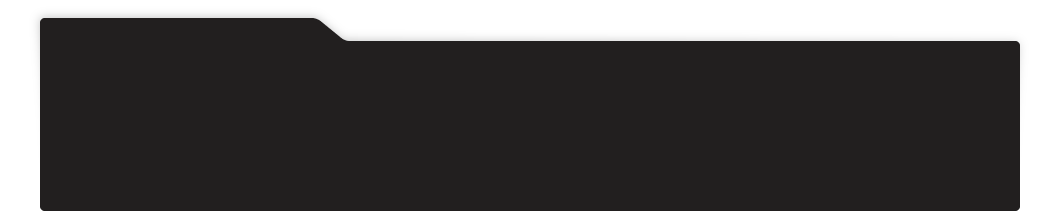
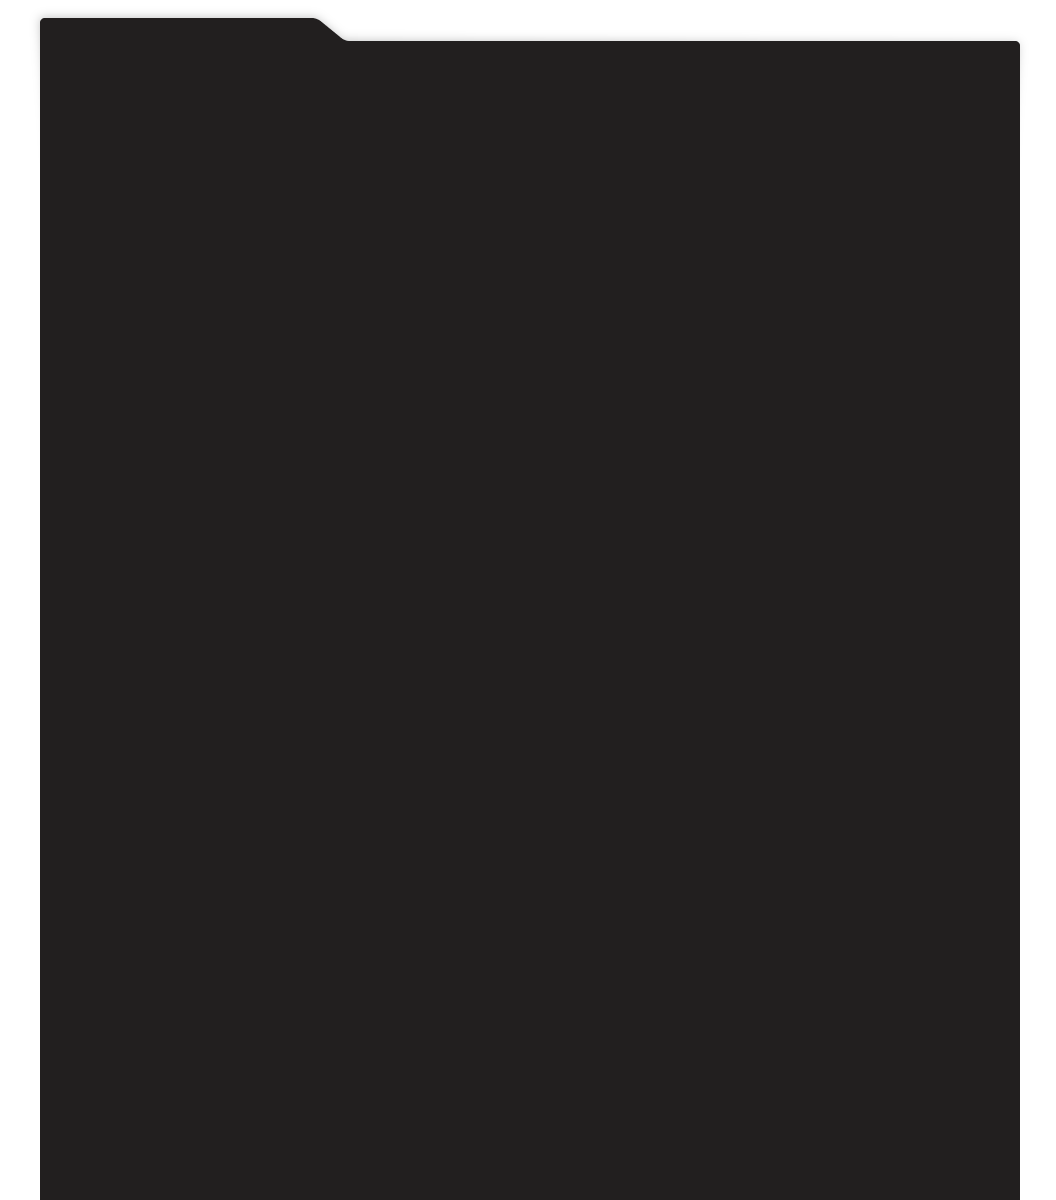
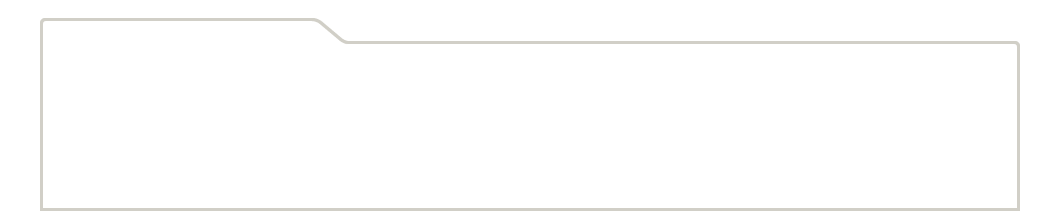
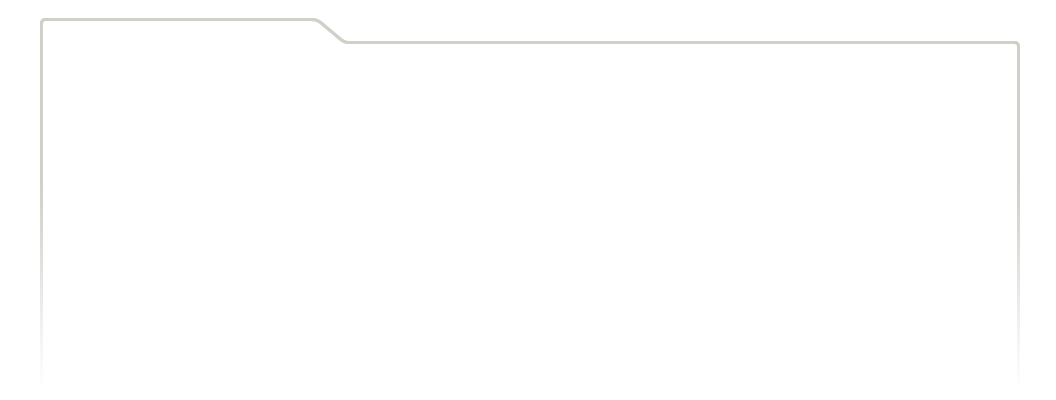
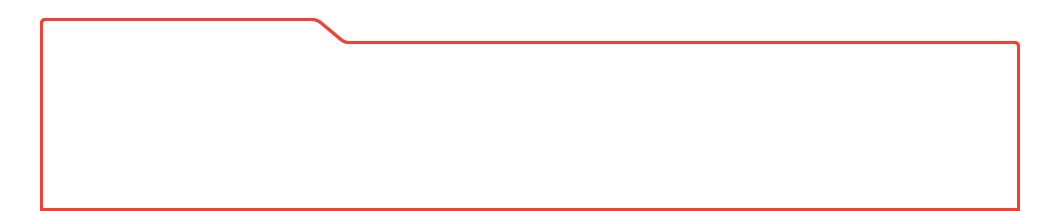
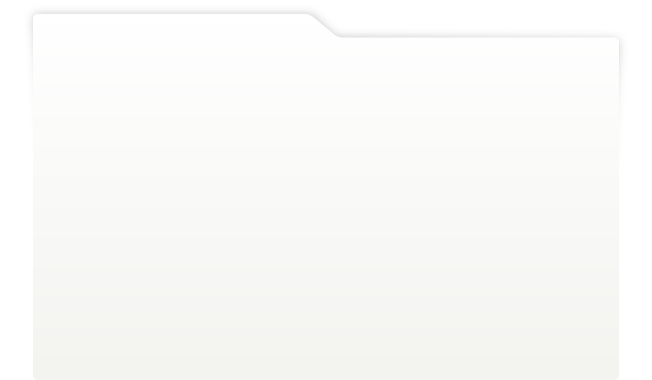
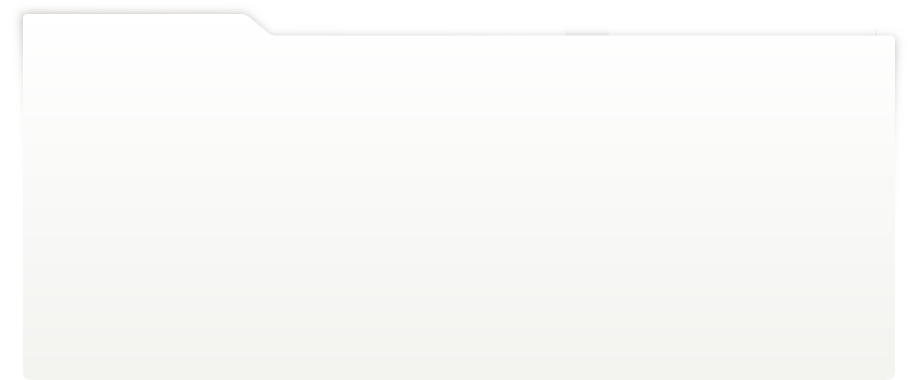
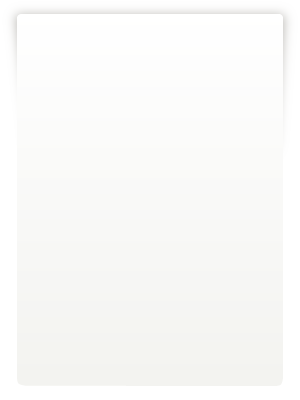
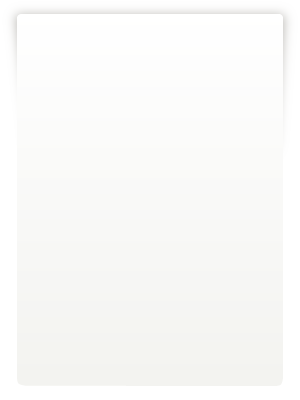
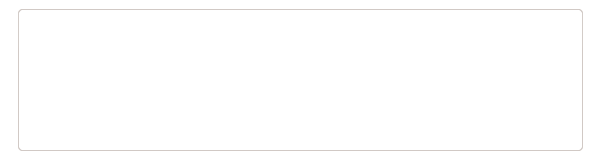
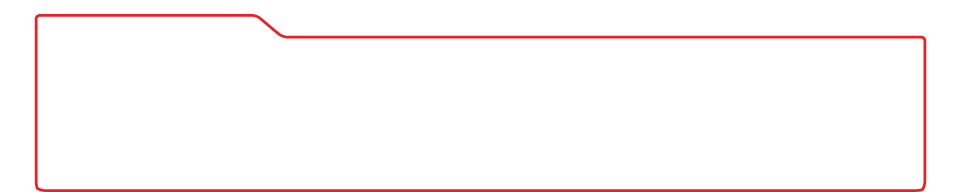
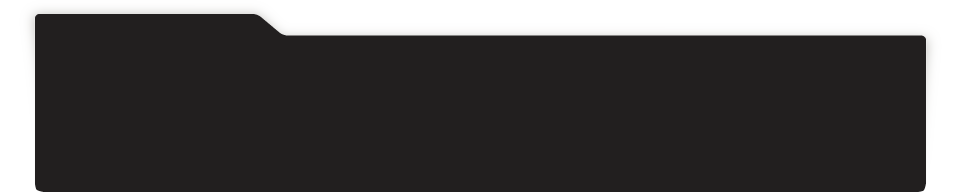
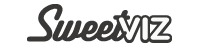
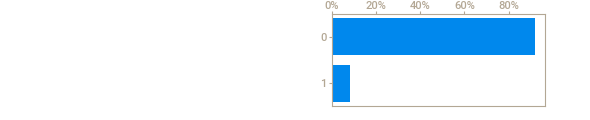
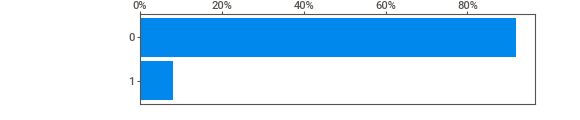
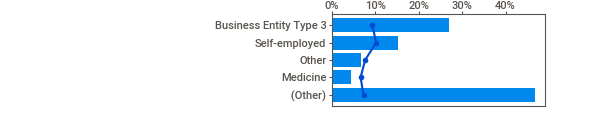
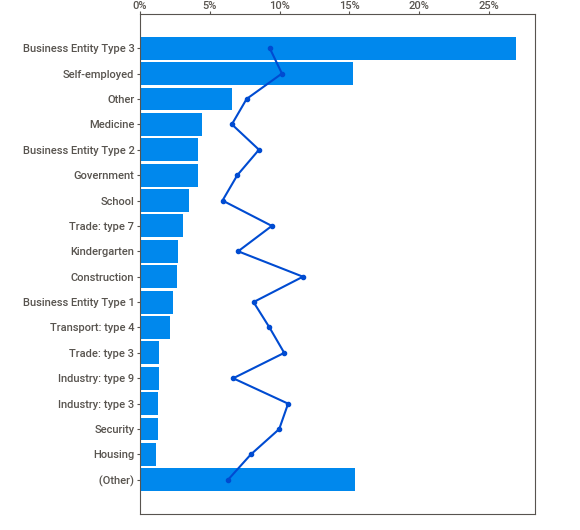
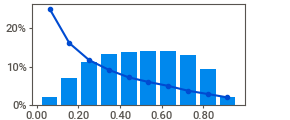
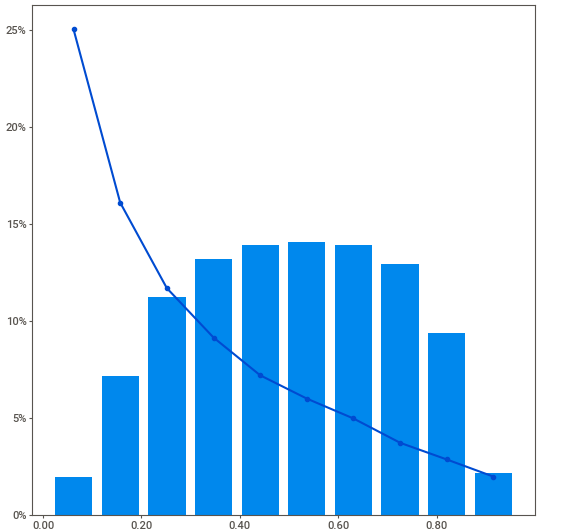
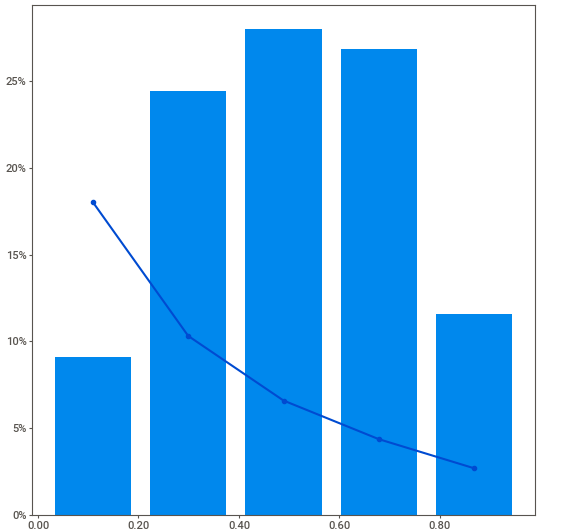
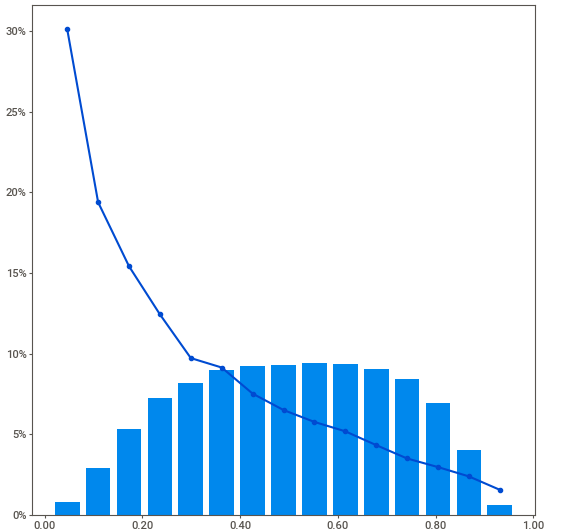
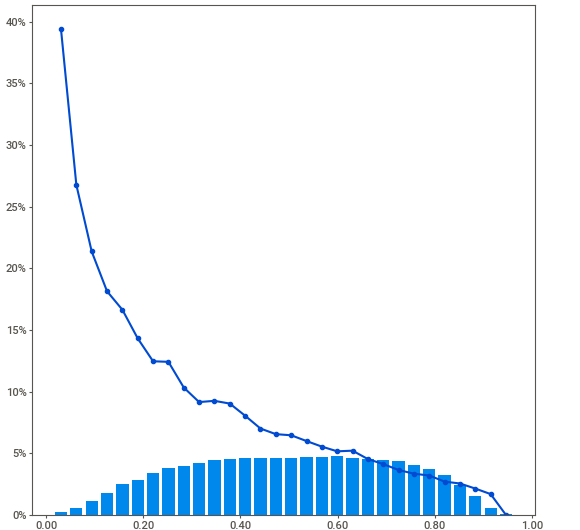
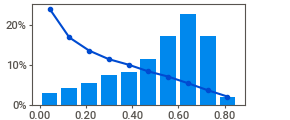
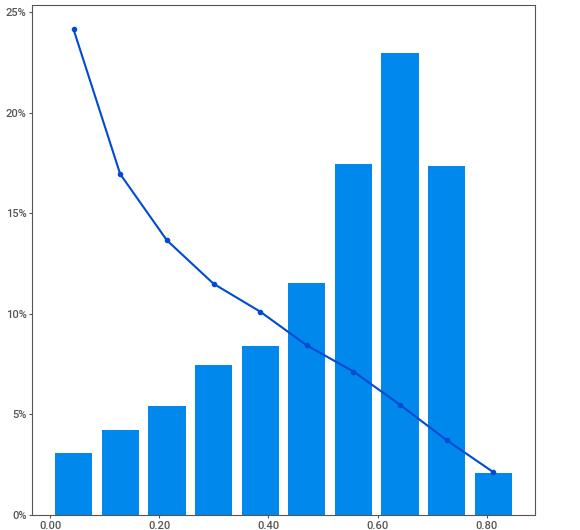
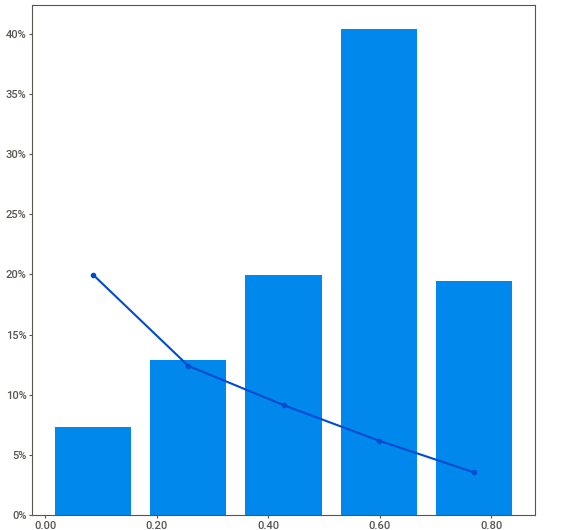
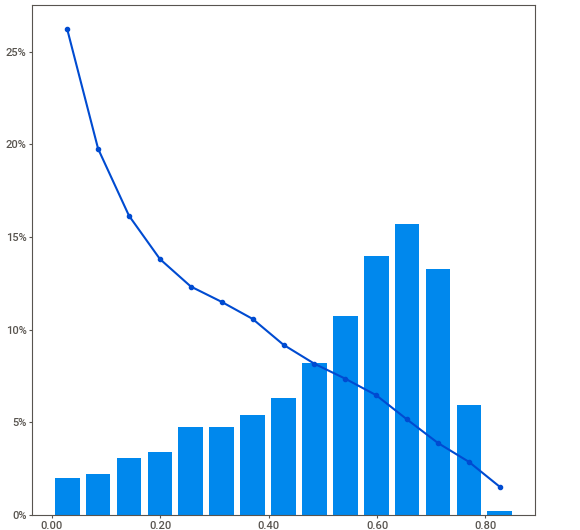
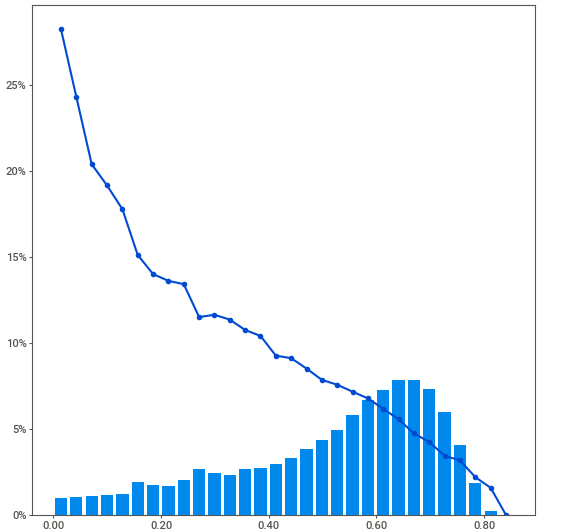
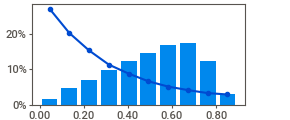
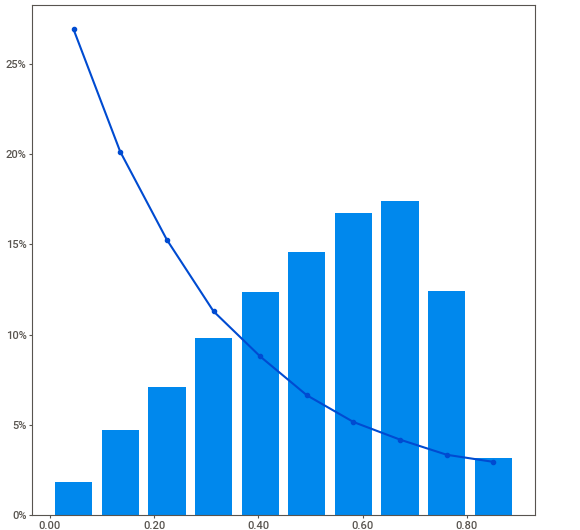
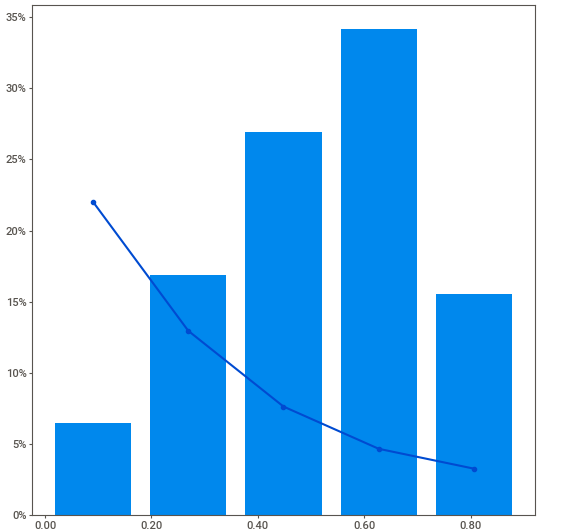
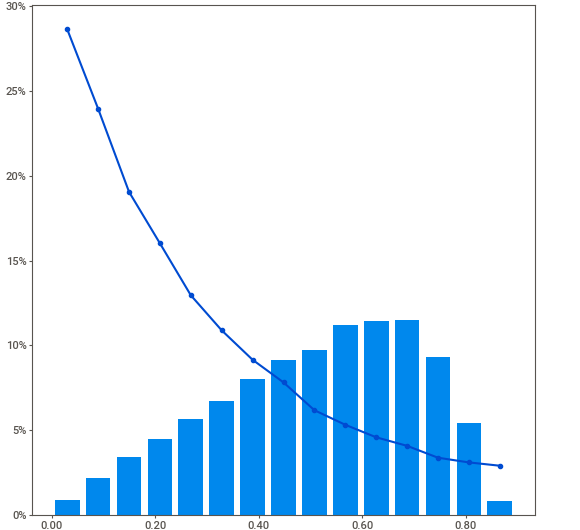
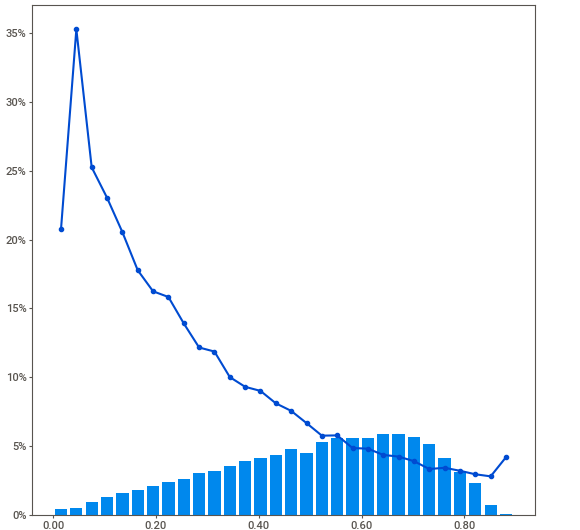
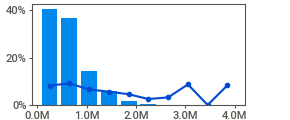
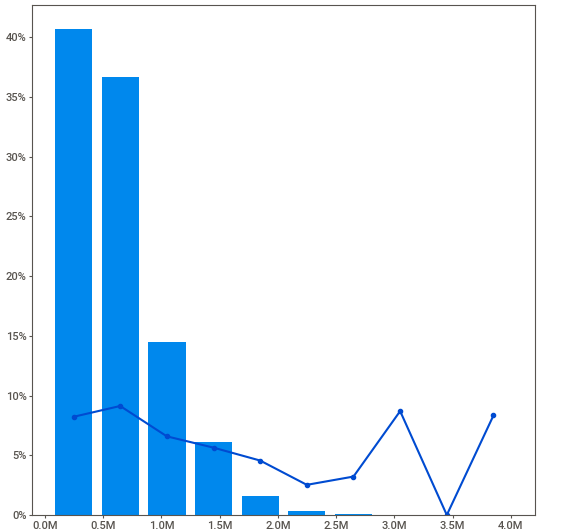
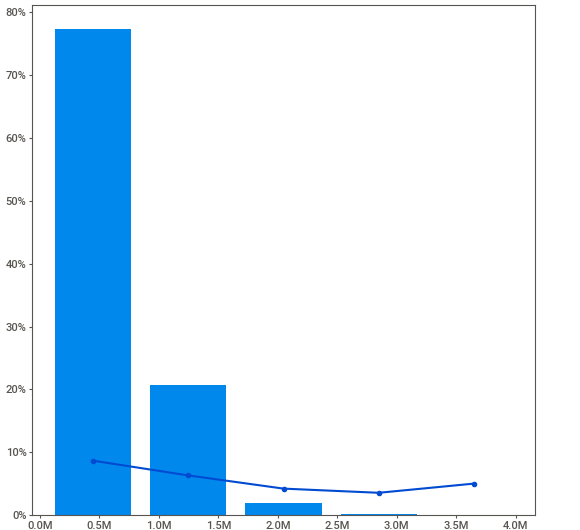
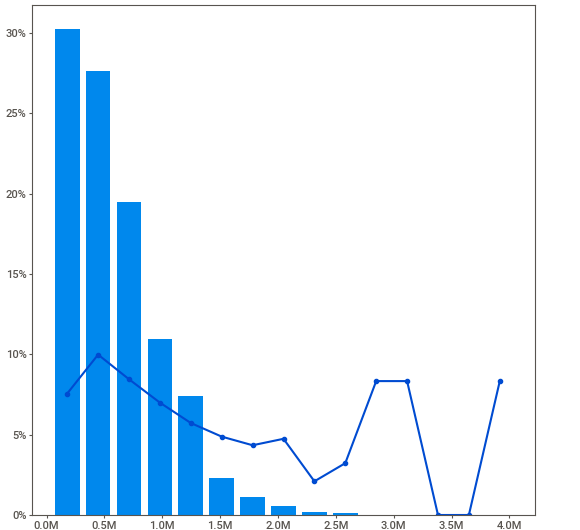
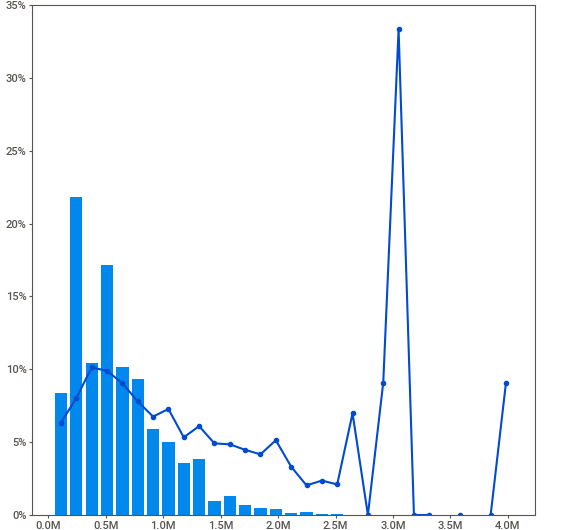
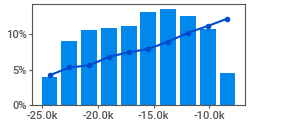
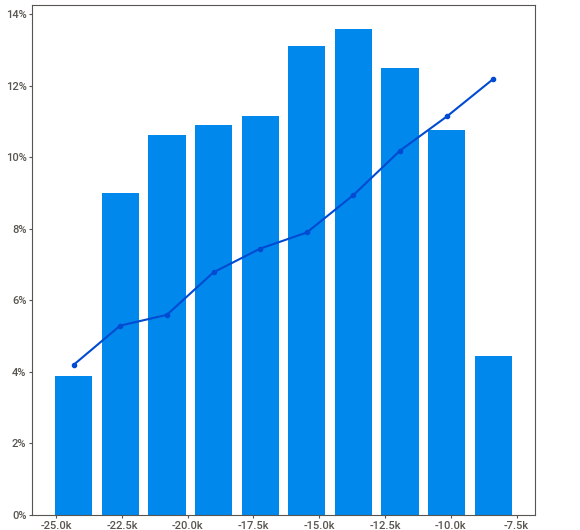
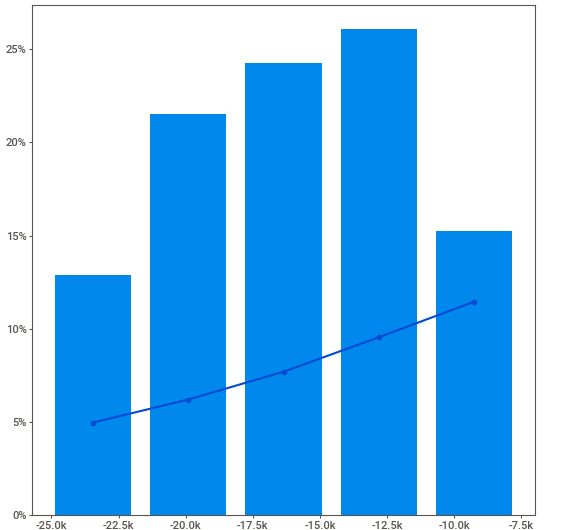
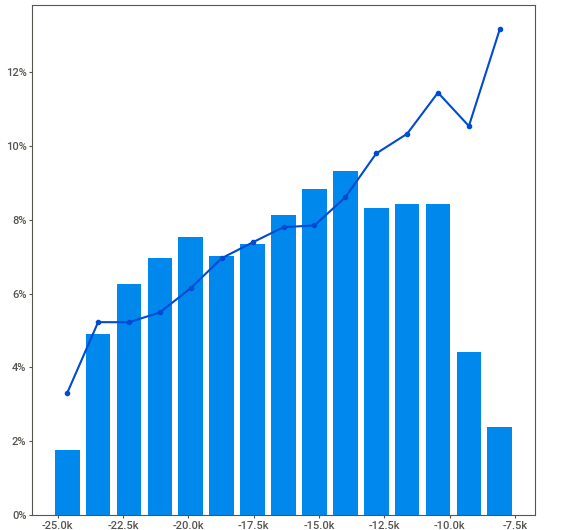
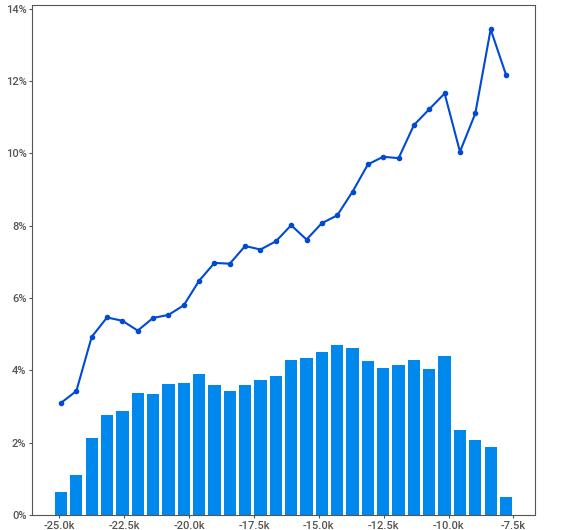
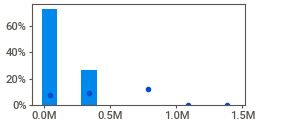
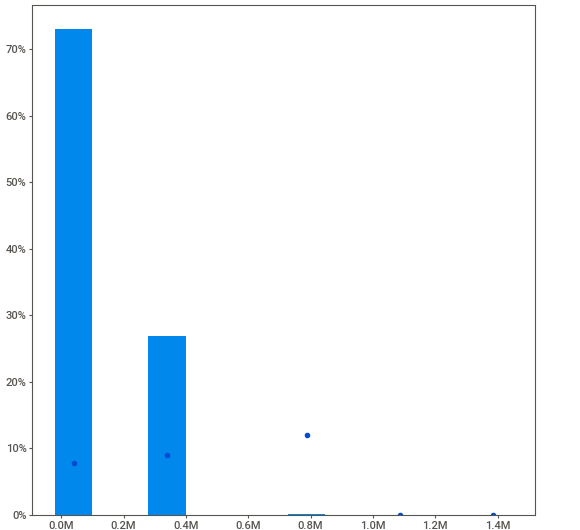
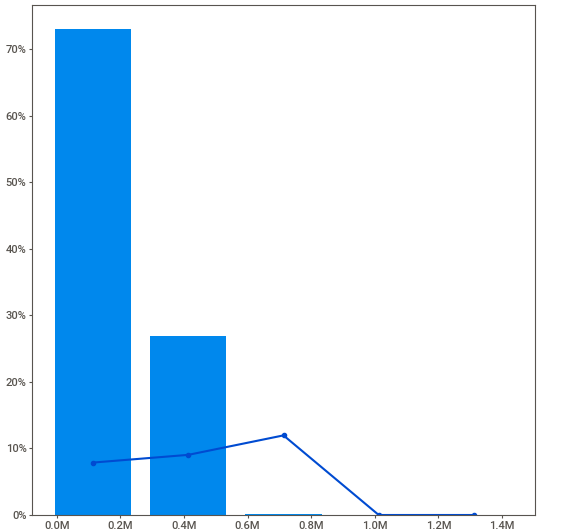
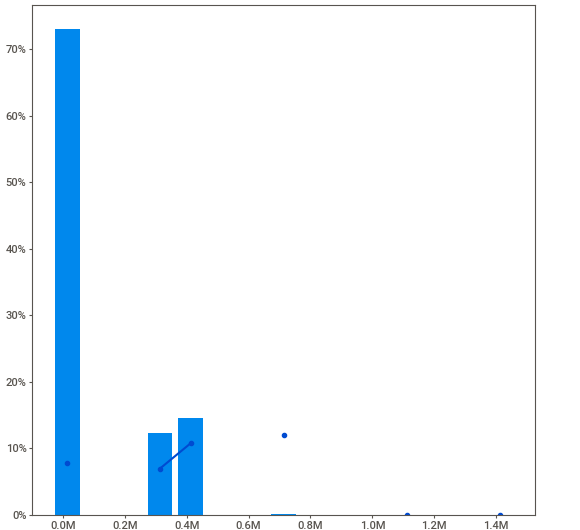
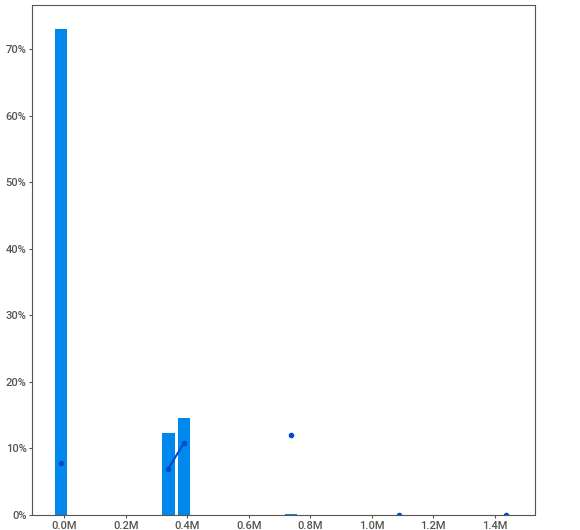
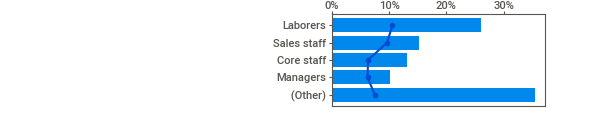
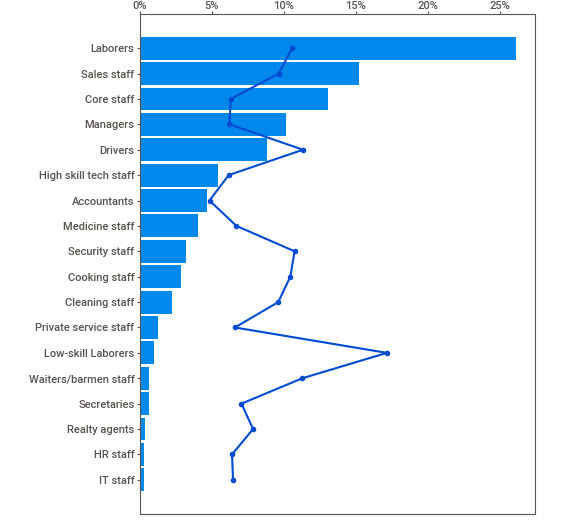
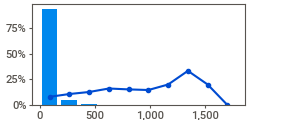
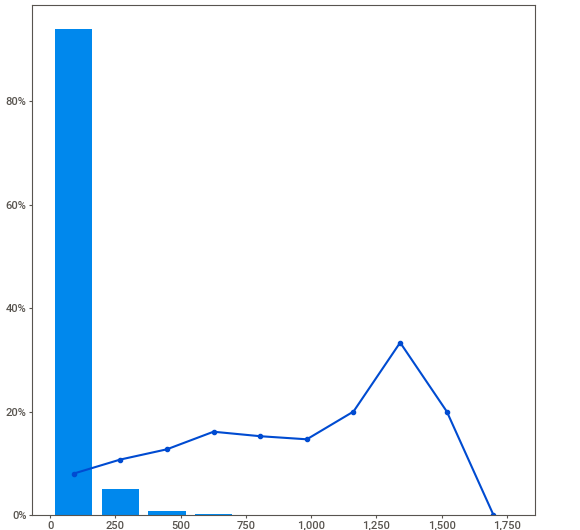
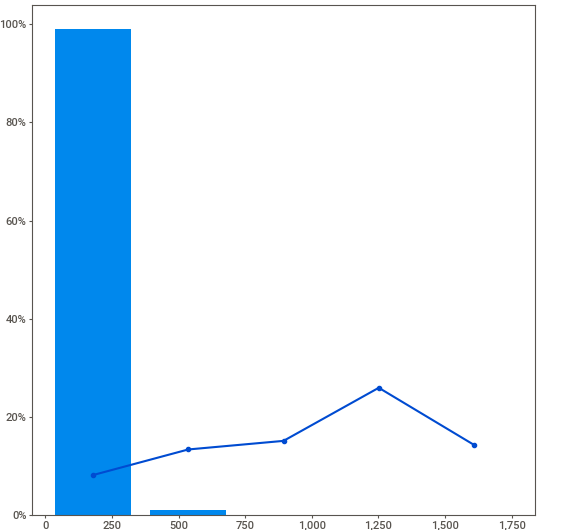
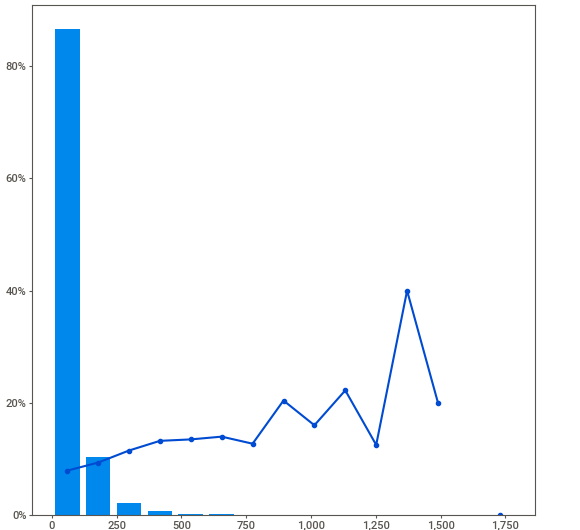
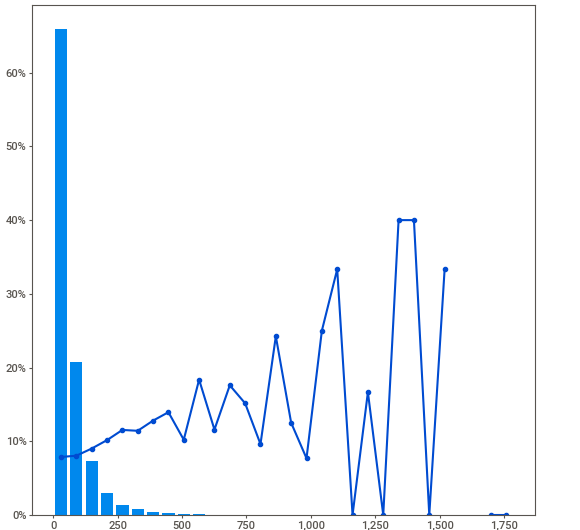
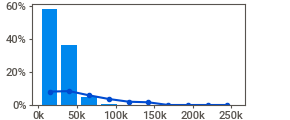
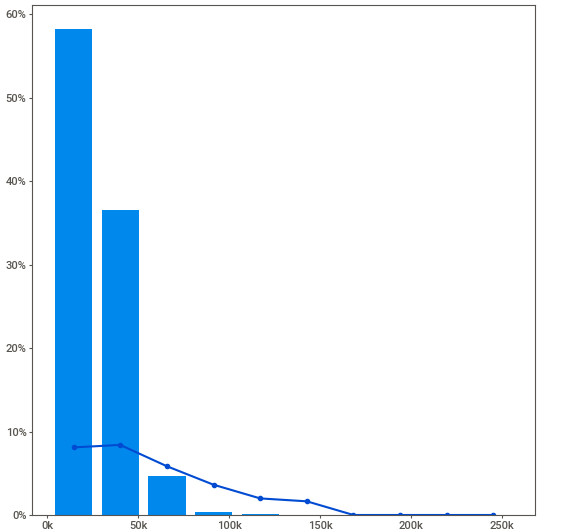
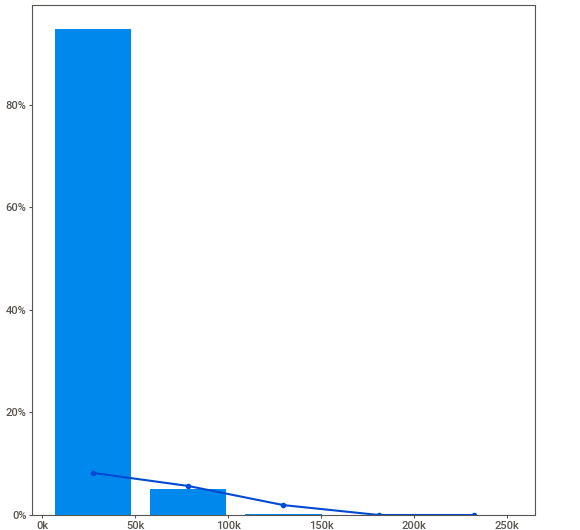
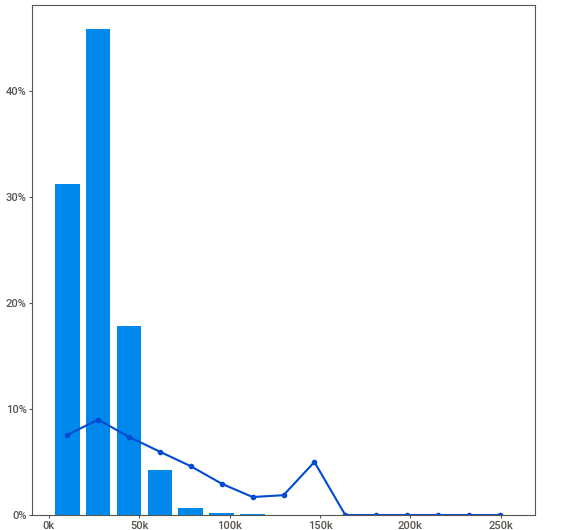
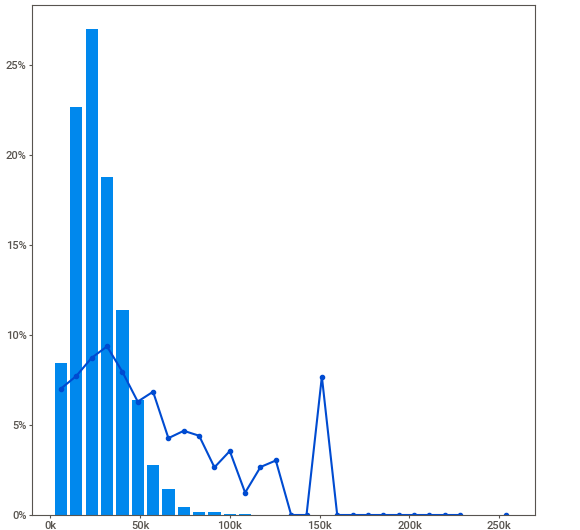
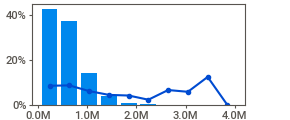
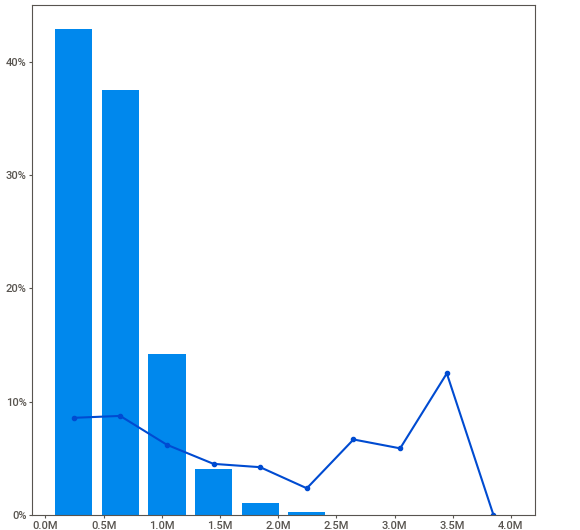
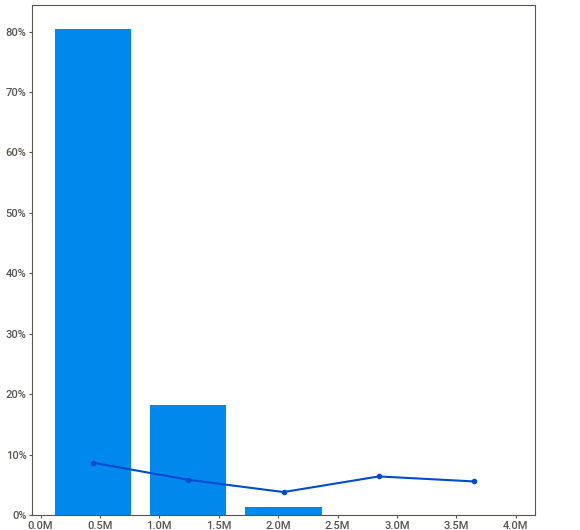
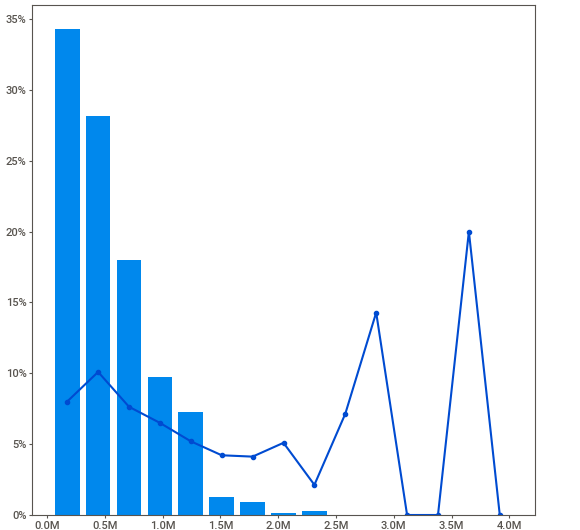
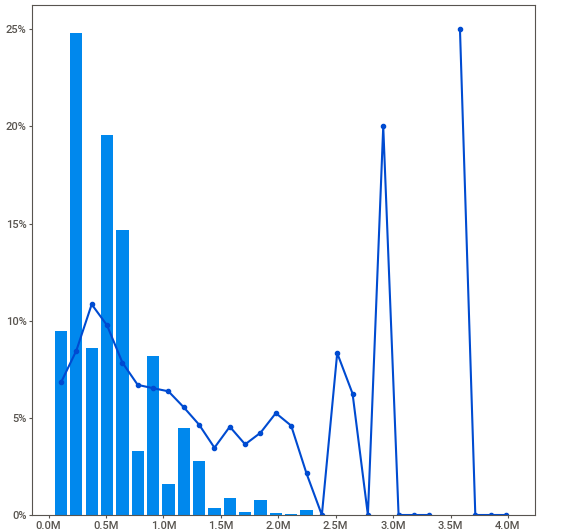
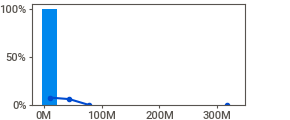
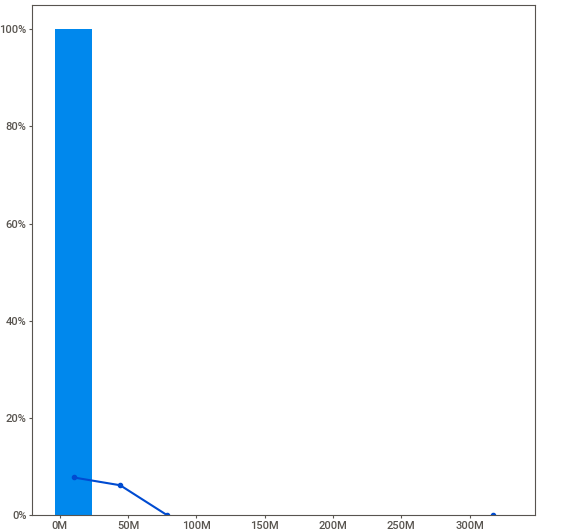
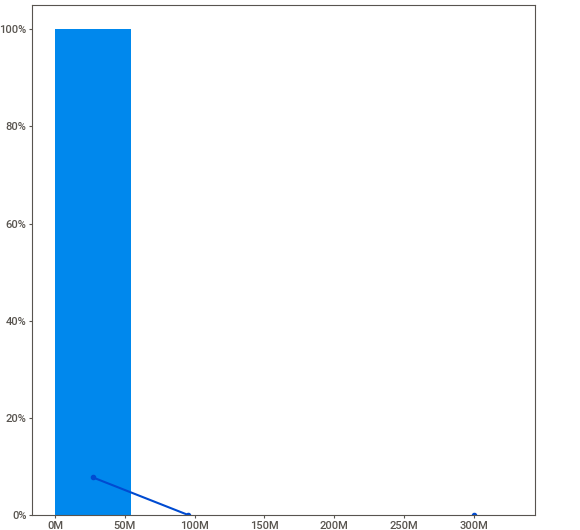
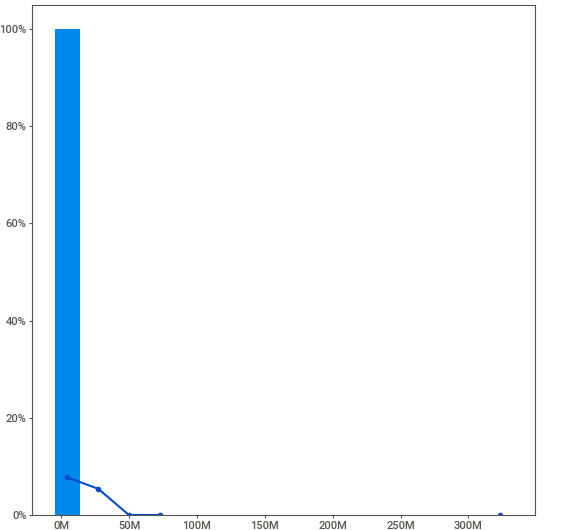
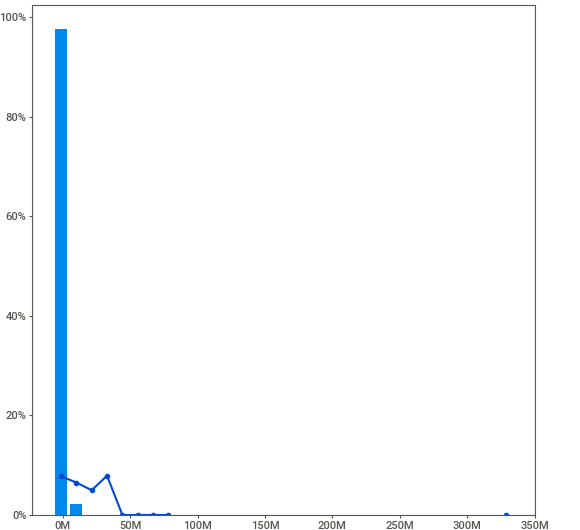
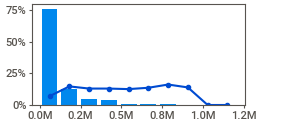
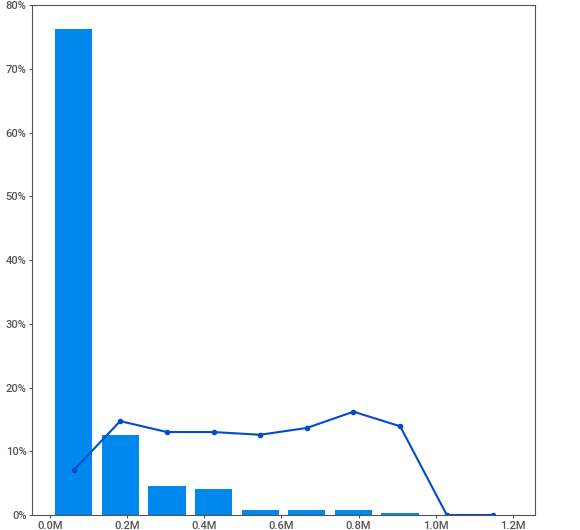
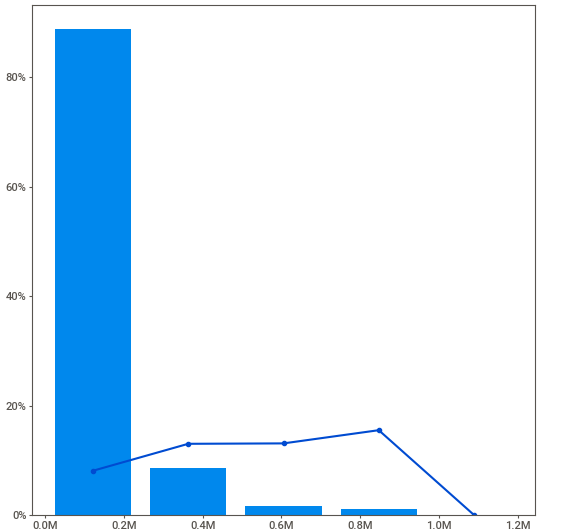
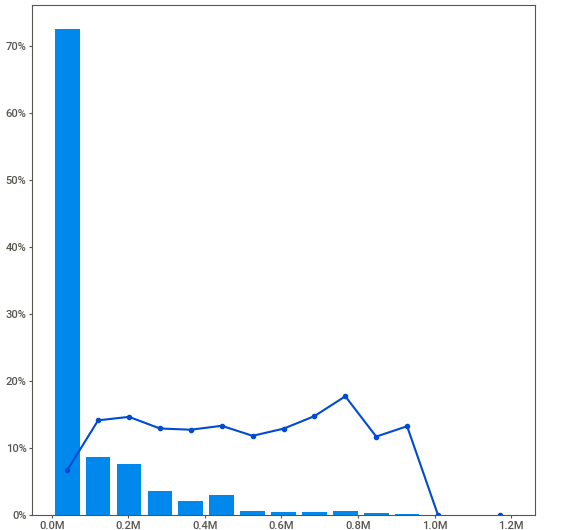
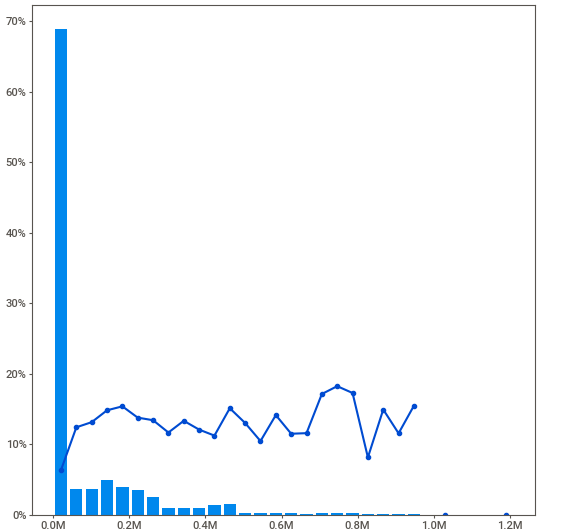
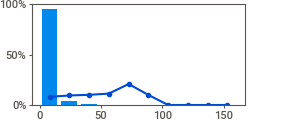
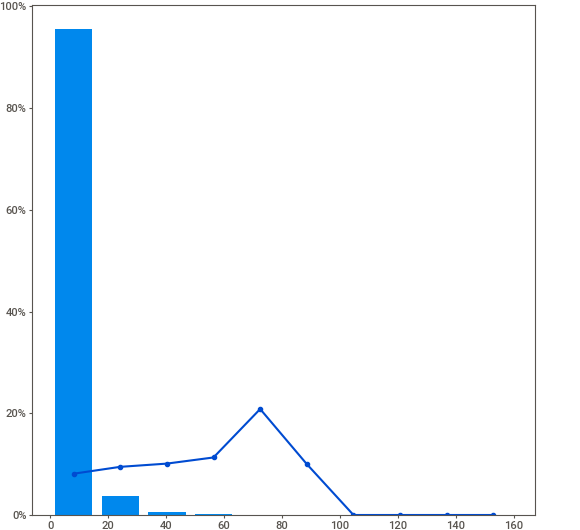
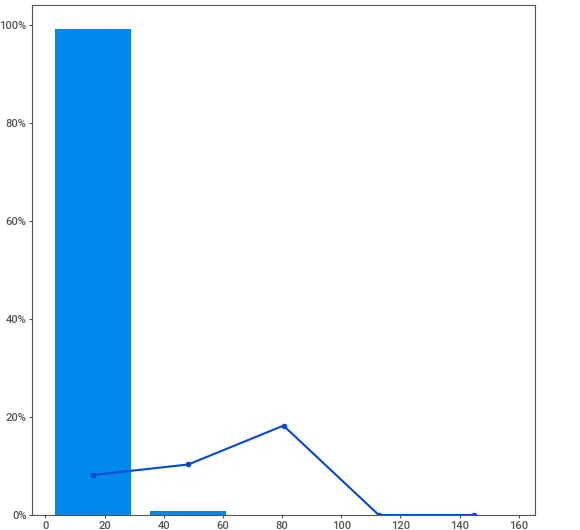
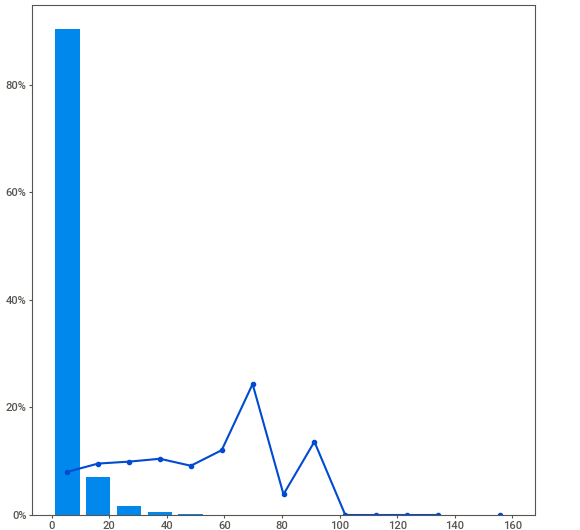
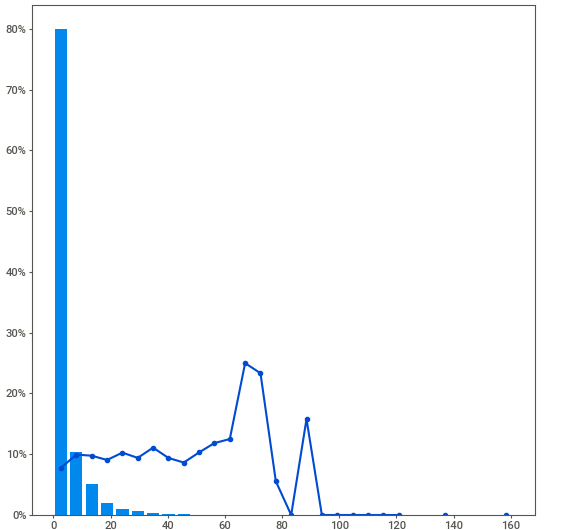
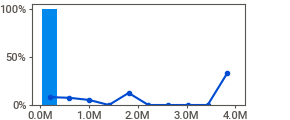
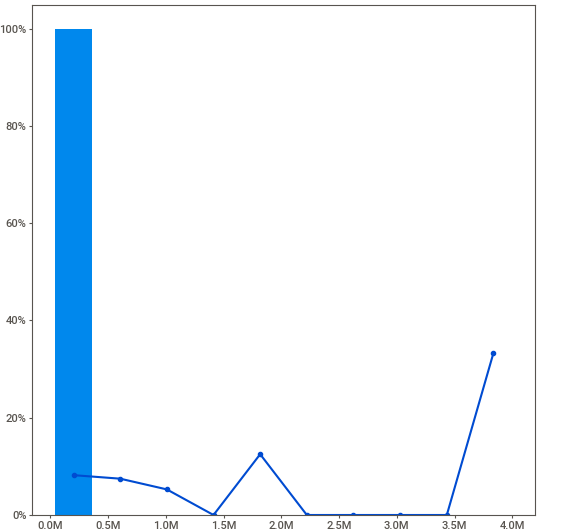
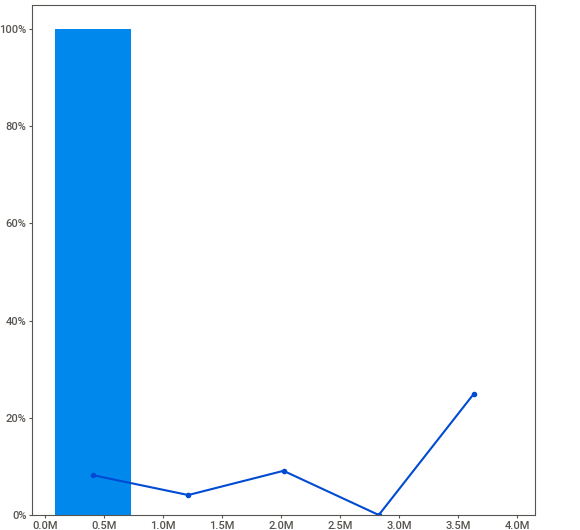
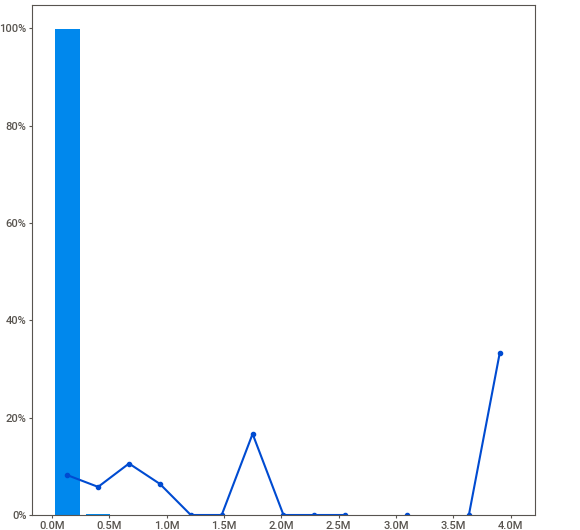
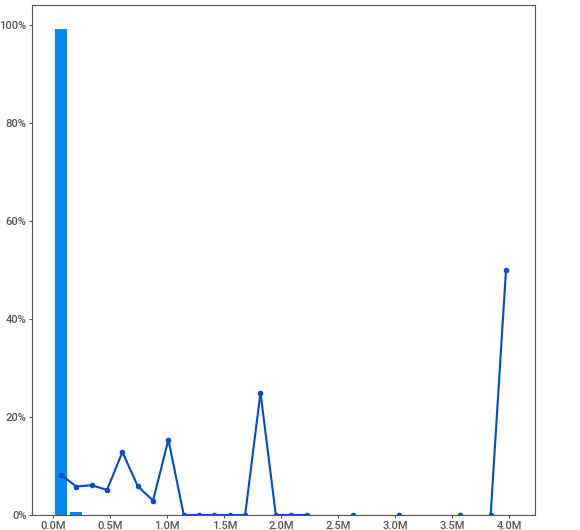
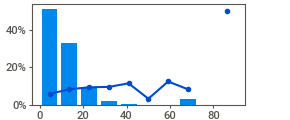
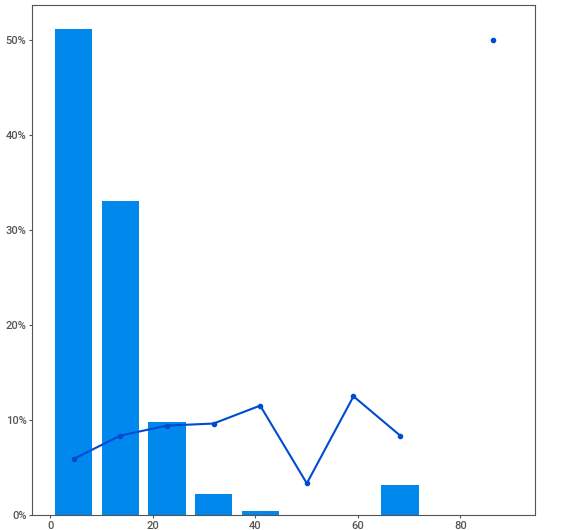
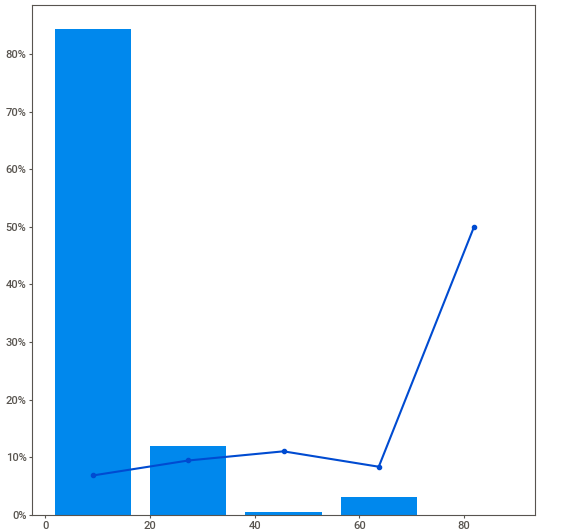
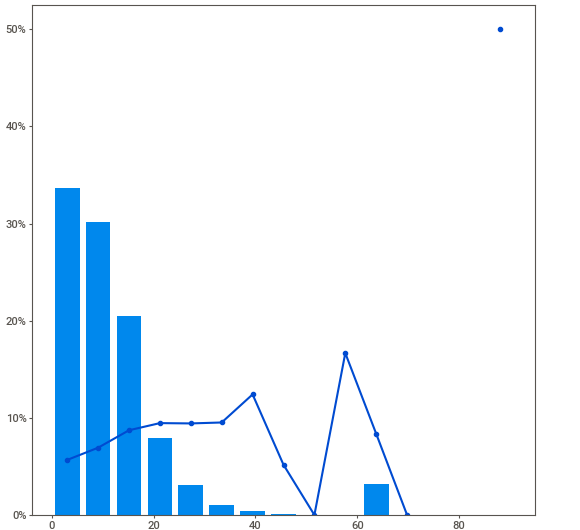
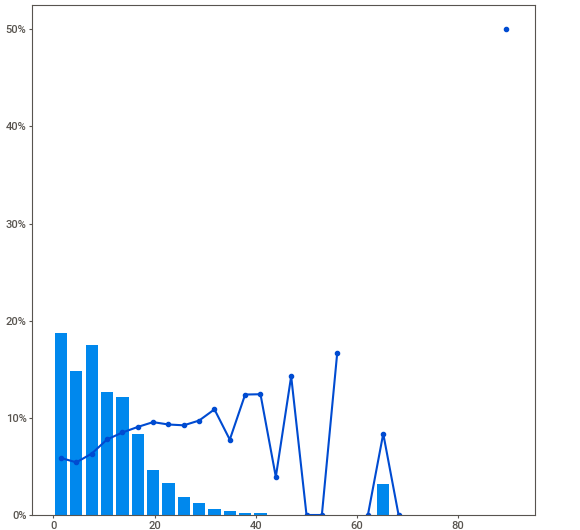
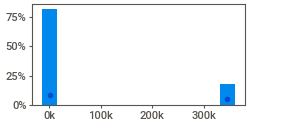
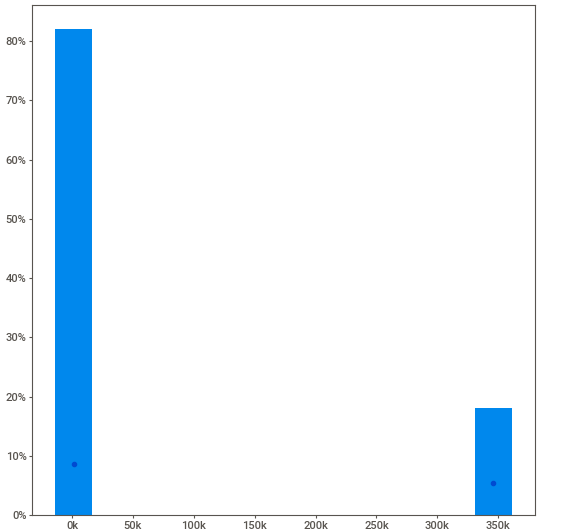
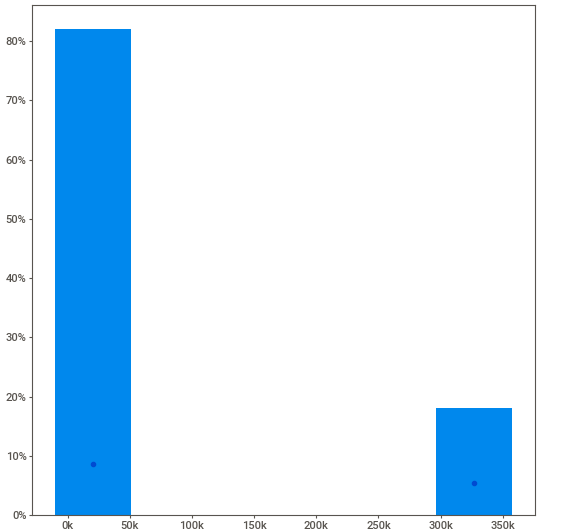
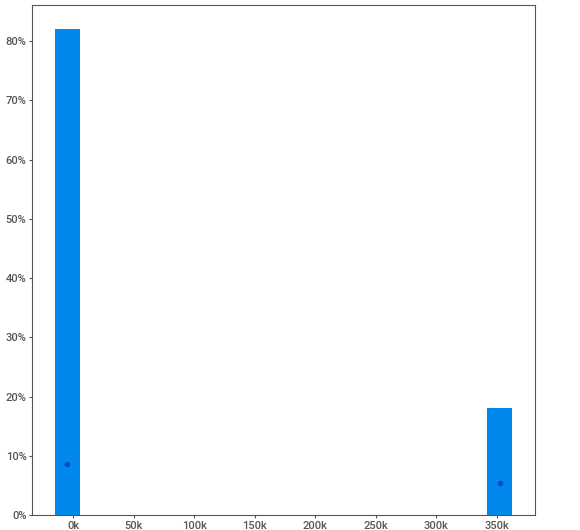
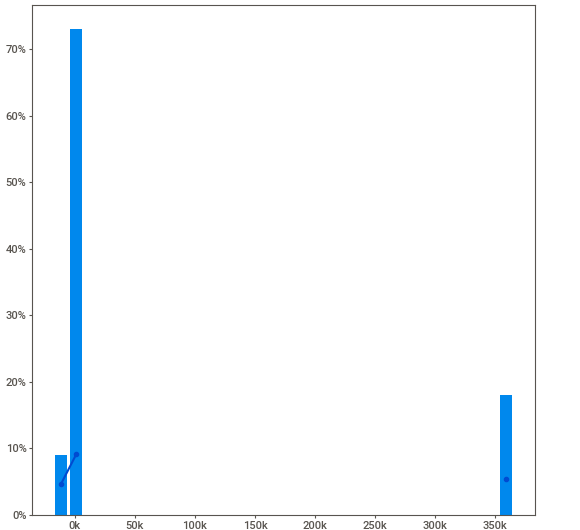
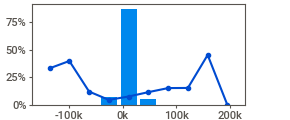
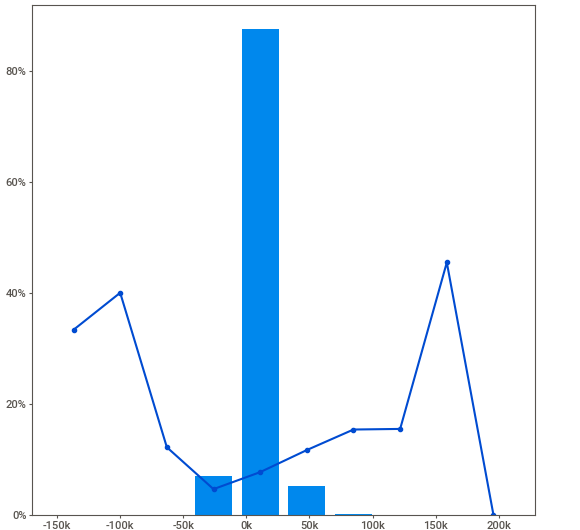
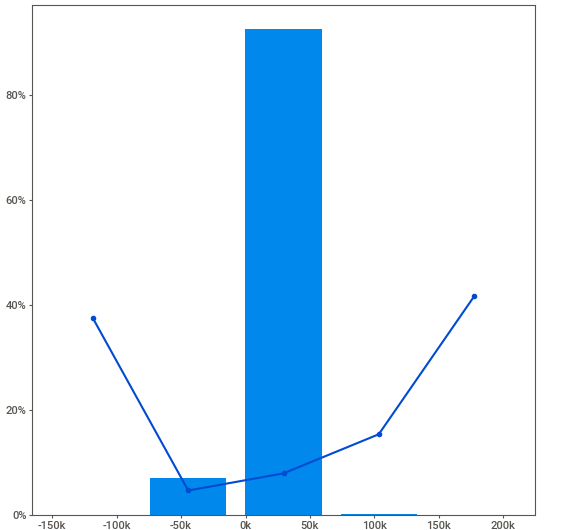
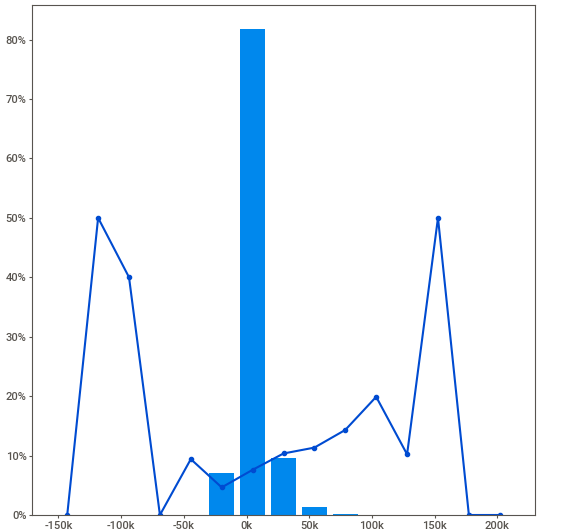
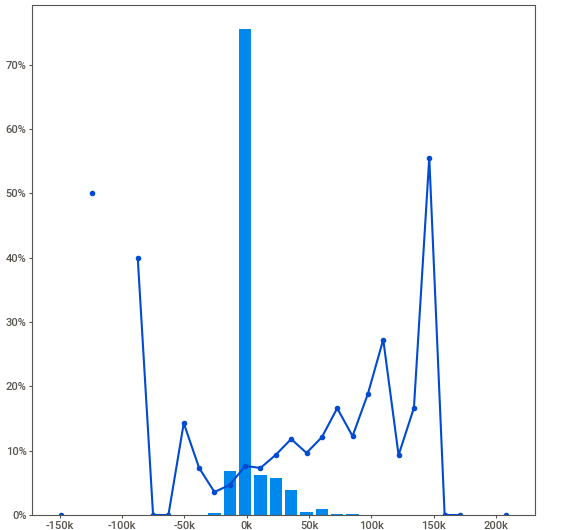
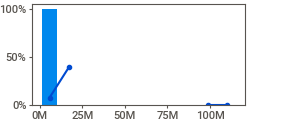
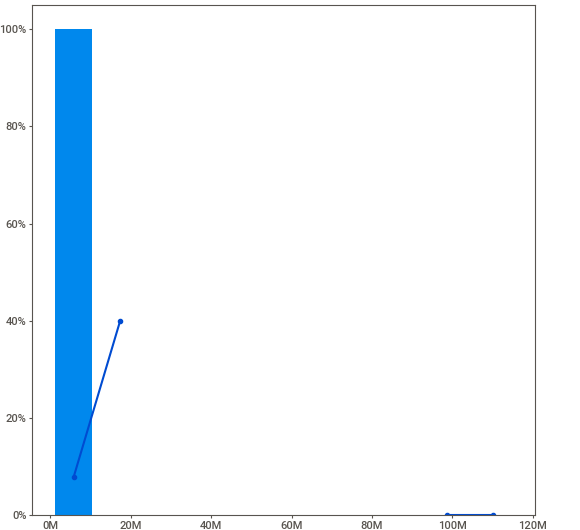
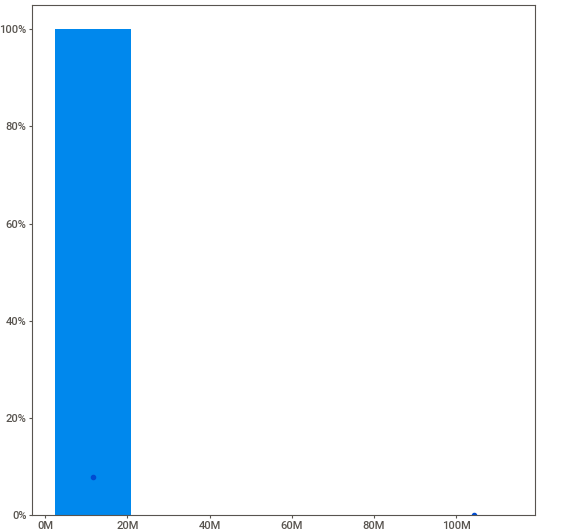
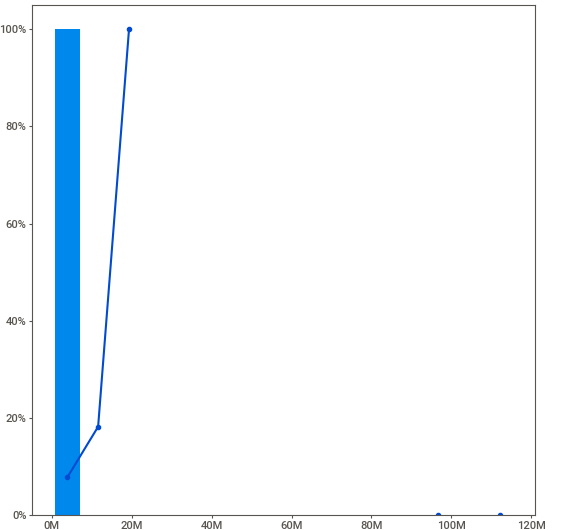
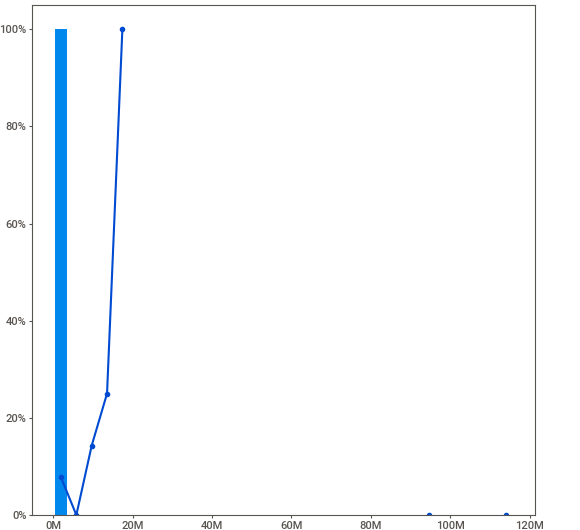
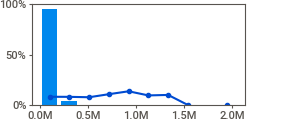
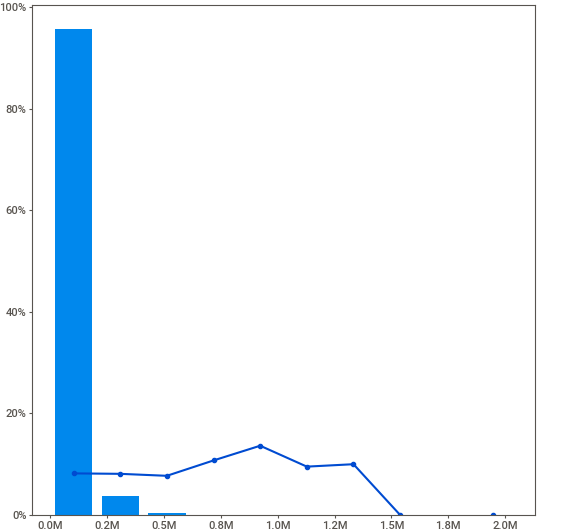
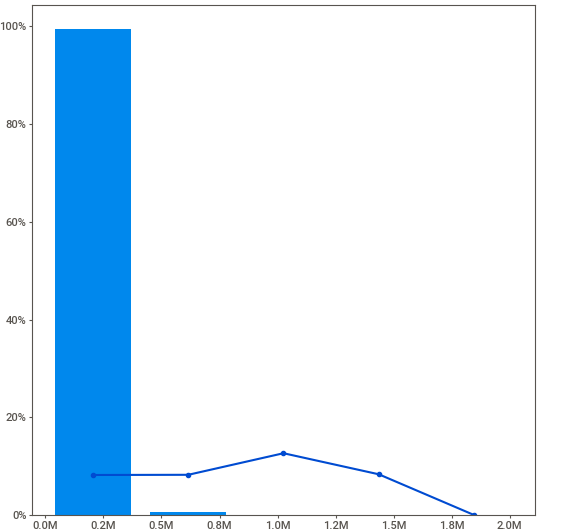
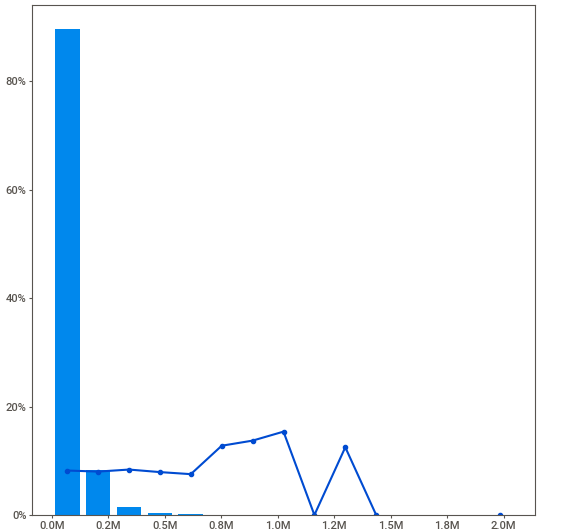
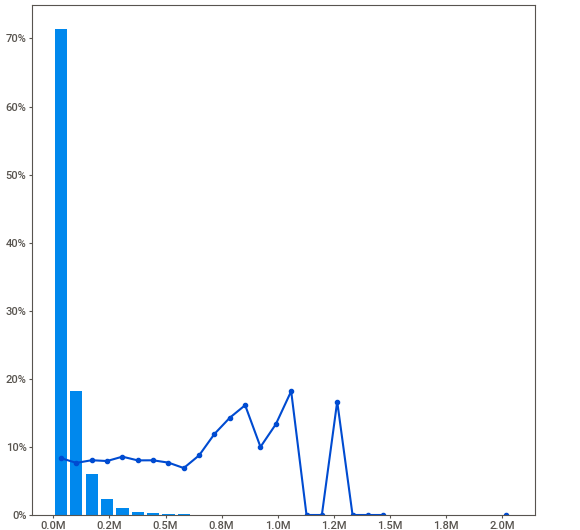
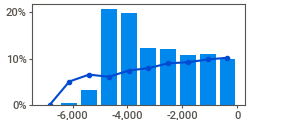
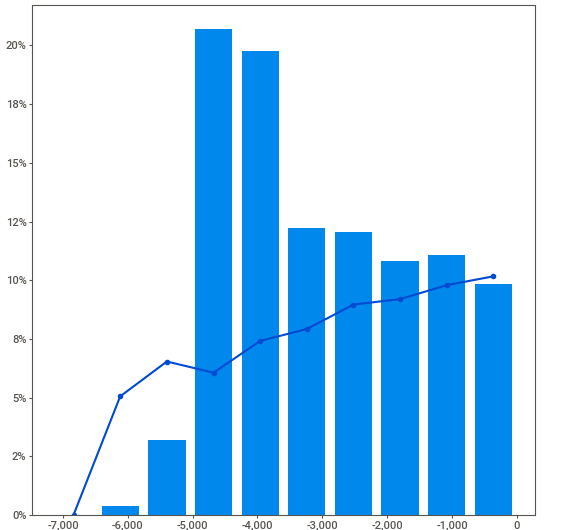
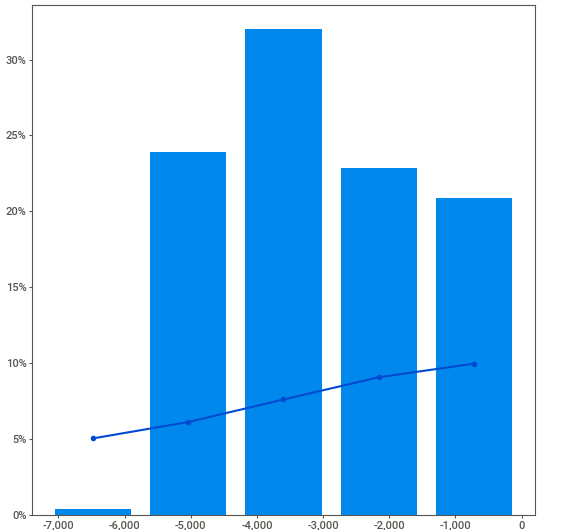
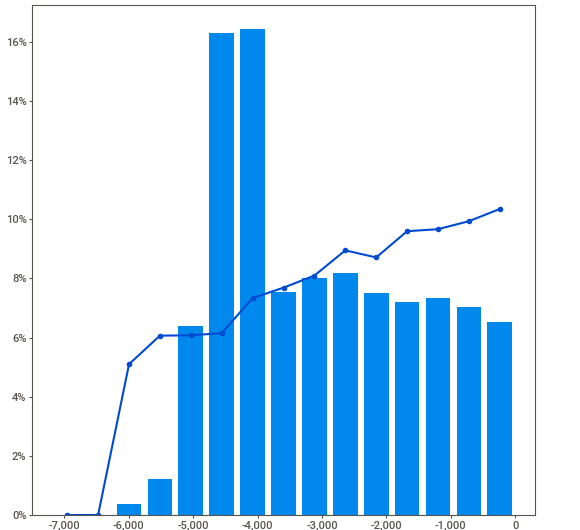
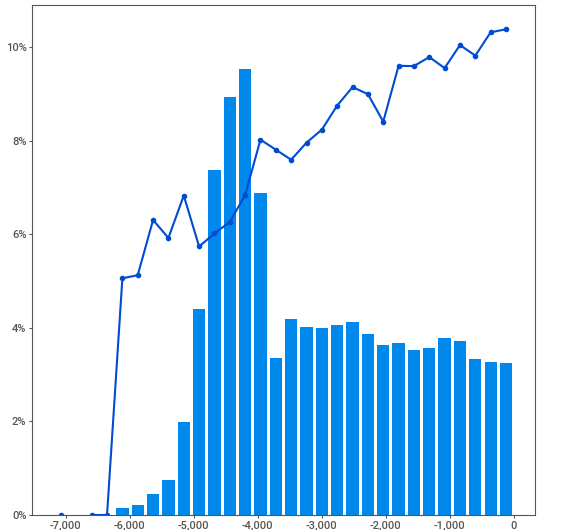
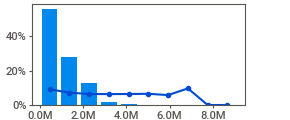
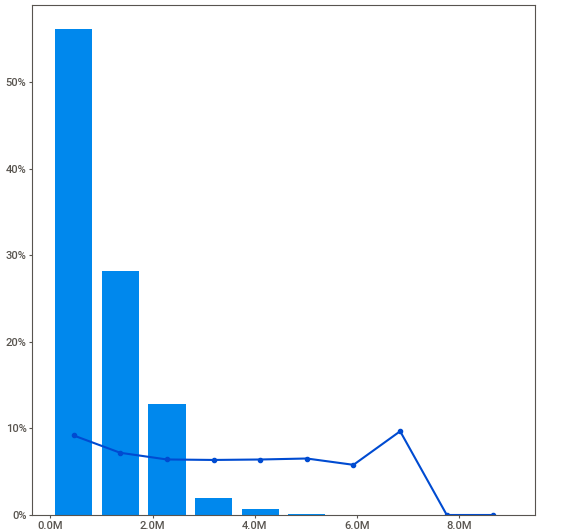
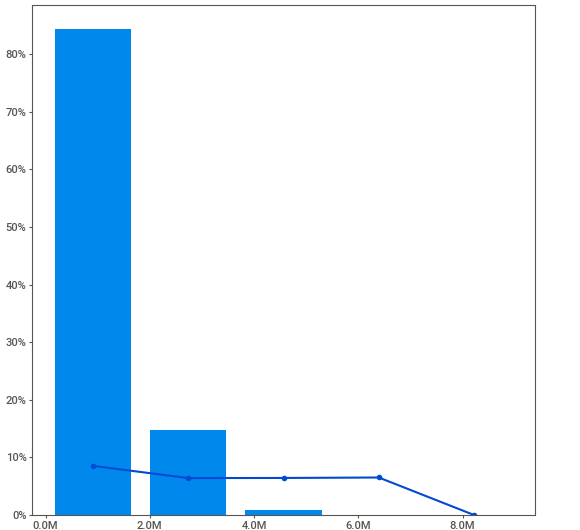
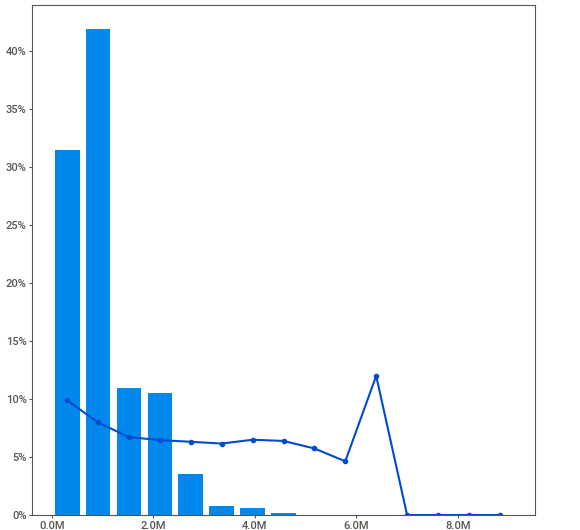
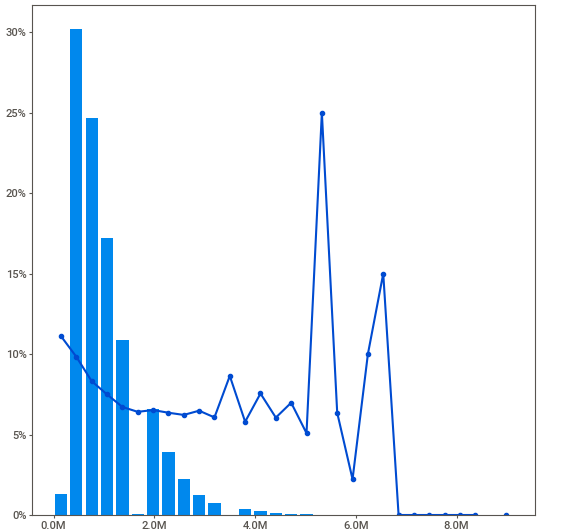
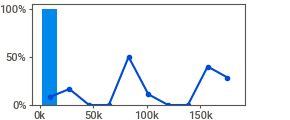
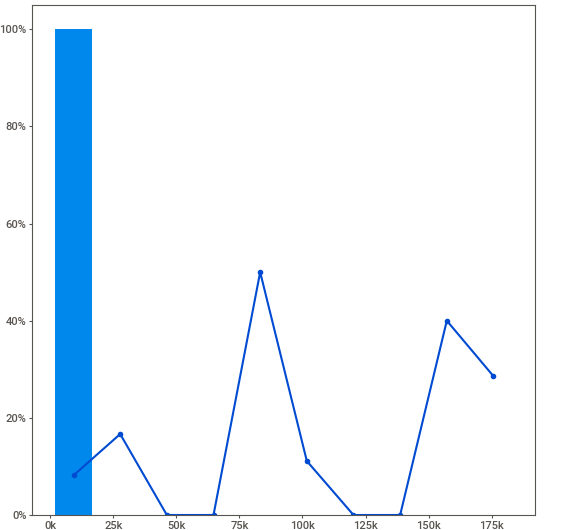
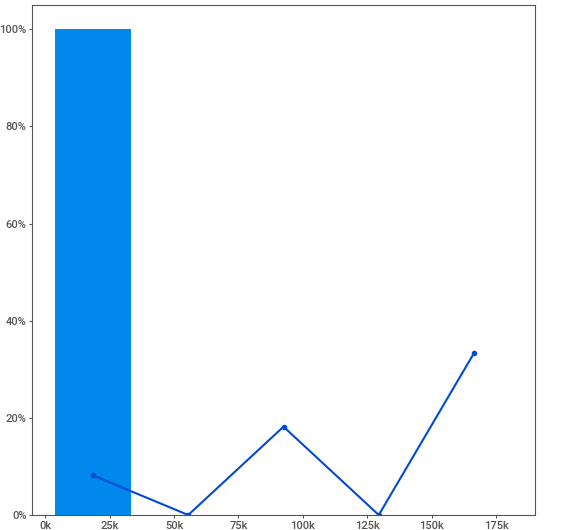
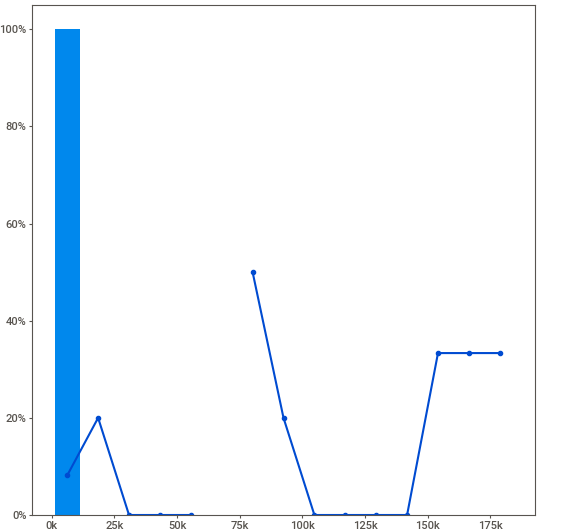
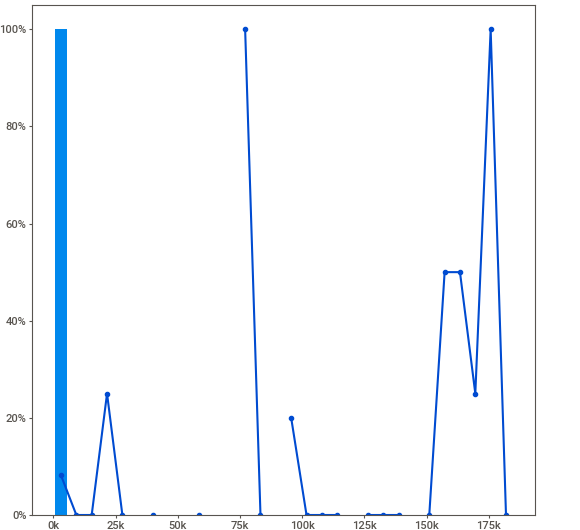
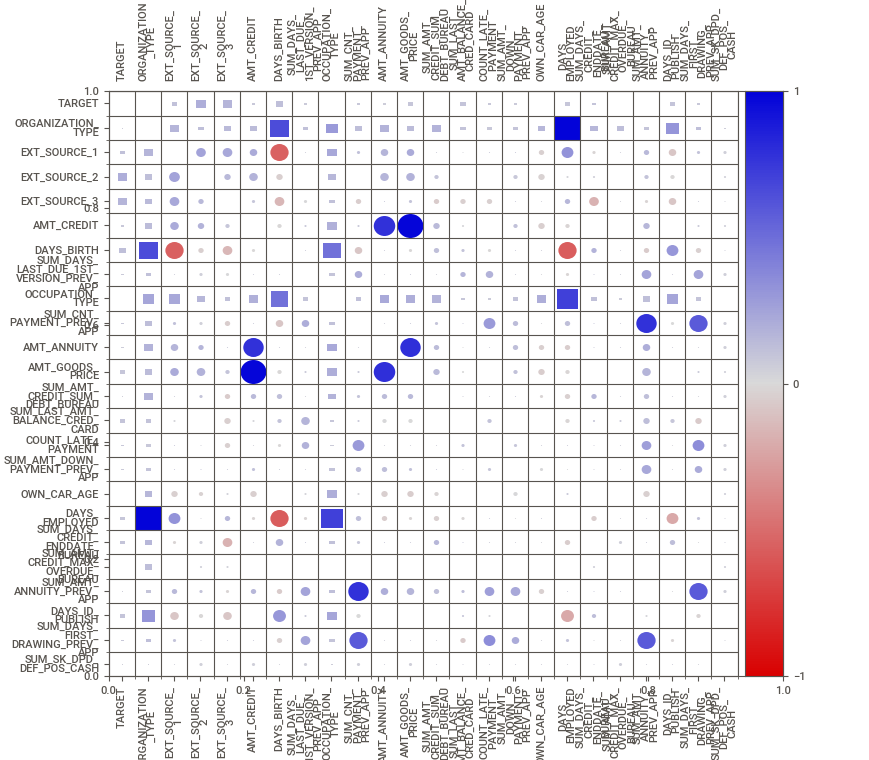
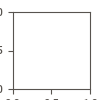

Report final_df_analysis_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
import sweetviz as sv

analysis_report = sv.analyze(final_df, target_feat="TARGET")

analysis_report.show_notebook()
analysis_report.show_html("final_df_analysis_report.html")

- High positive correlation of: EXT_SOURCE_* with TARGET, DAYS_BIRTH with TARGET and  ORGANIZATION_TYPE with DAYS_EMPLOYED
- Dataset is highly imbalanced

#### Detailed analysis
In this section we will focus on insights from the analysis report and the most important feature in predicting the TARGET

##### ORGANIZATION_TYPE

What are the most common organization types among clients?

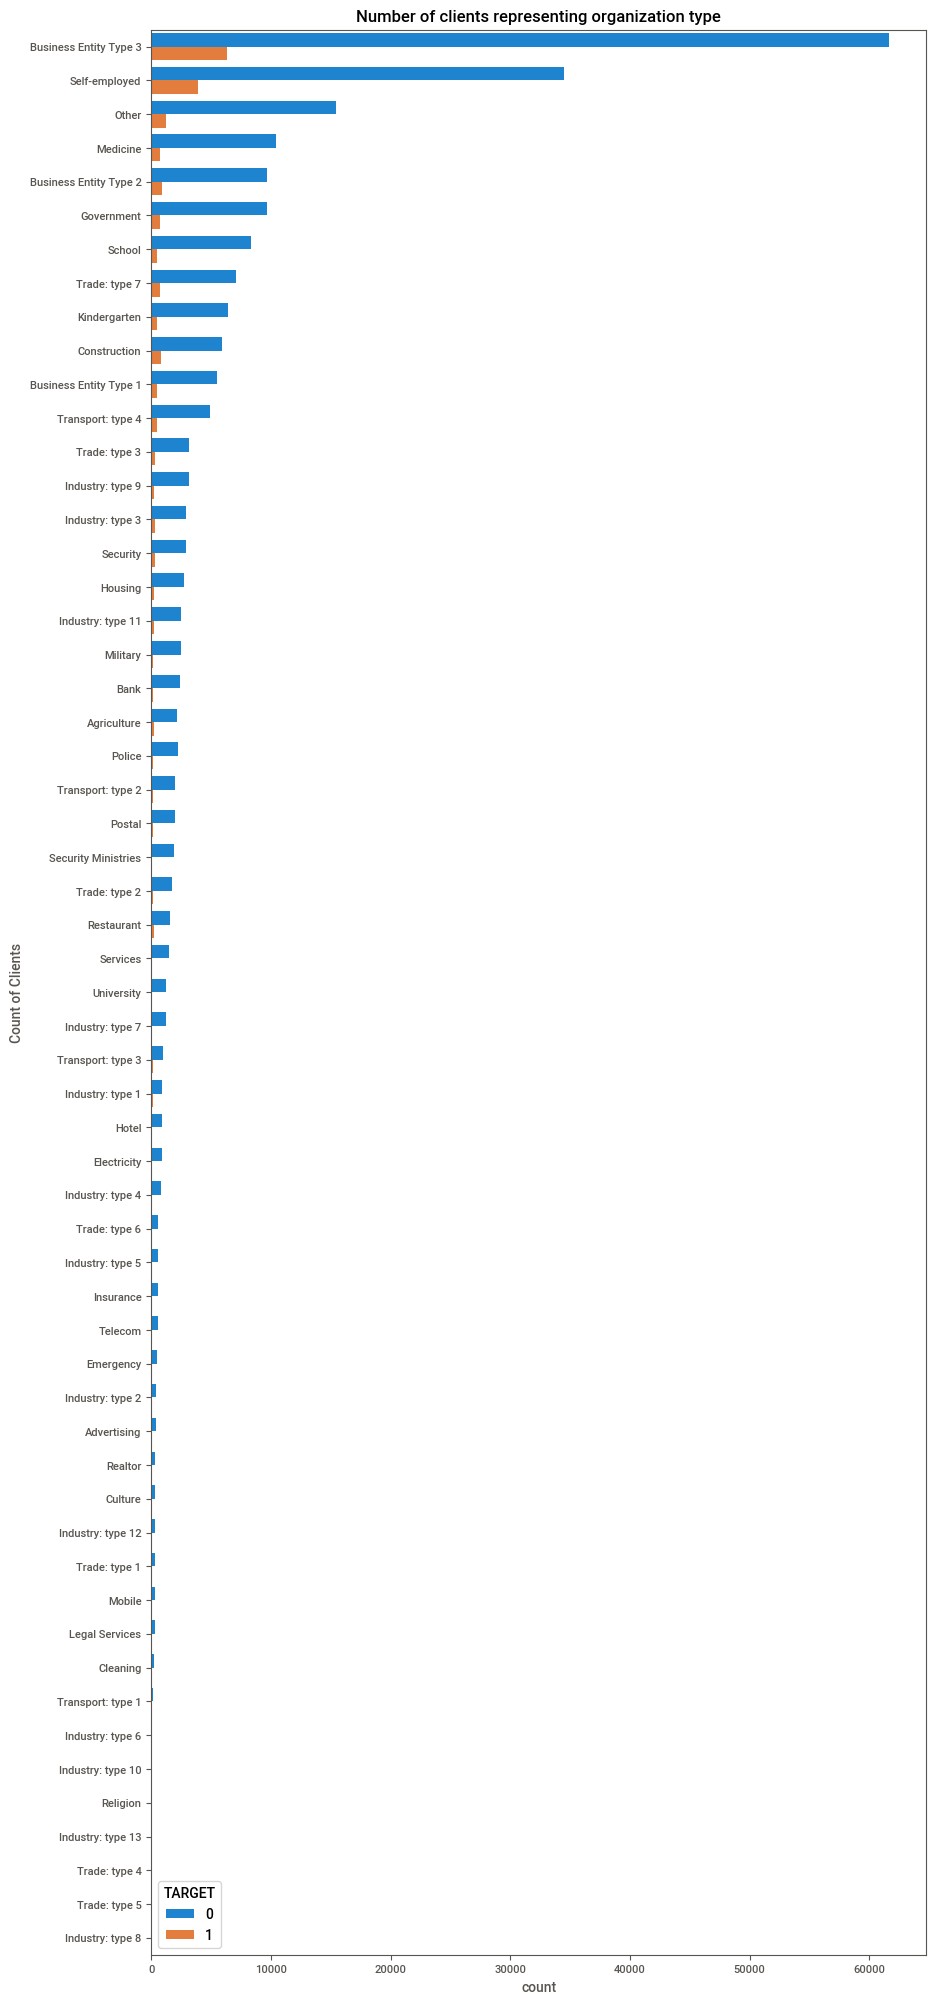

In [ ]:
plt.figure(figsize=(10, 25))
sns.countplot(
    data=final_df,
    y="ORGANIZATION_TYPE",
    hue="TARGET",
    order=final_df["ORGANIZATION_TYPE"].value_counts().index,
)

plt.ylabel("Organization Type")
plt.ylabel("Count of Clients")
plt.title("Number of clients representing organization type")
plt.show()

- The most frequent organization type among clients are Business Entity Type 3, Self-employed and Other

What is the Prevalence of clients with financial difficulties among clients by organization type?

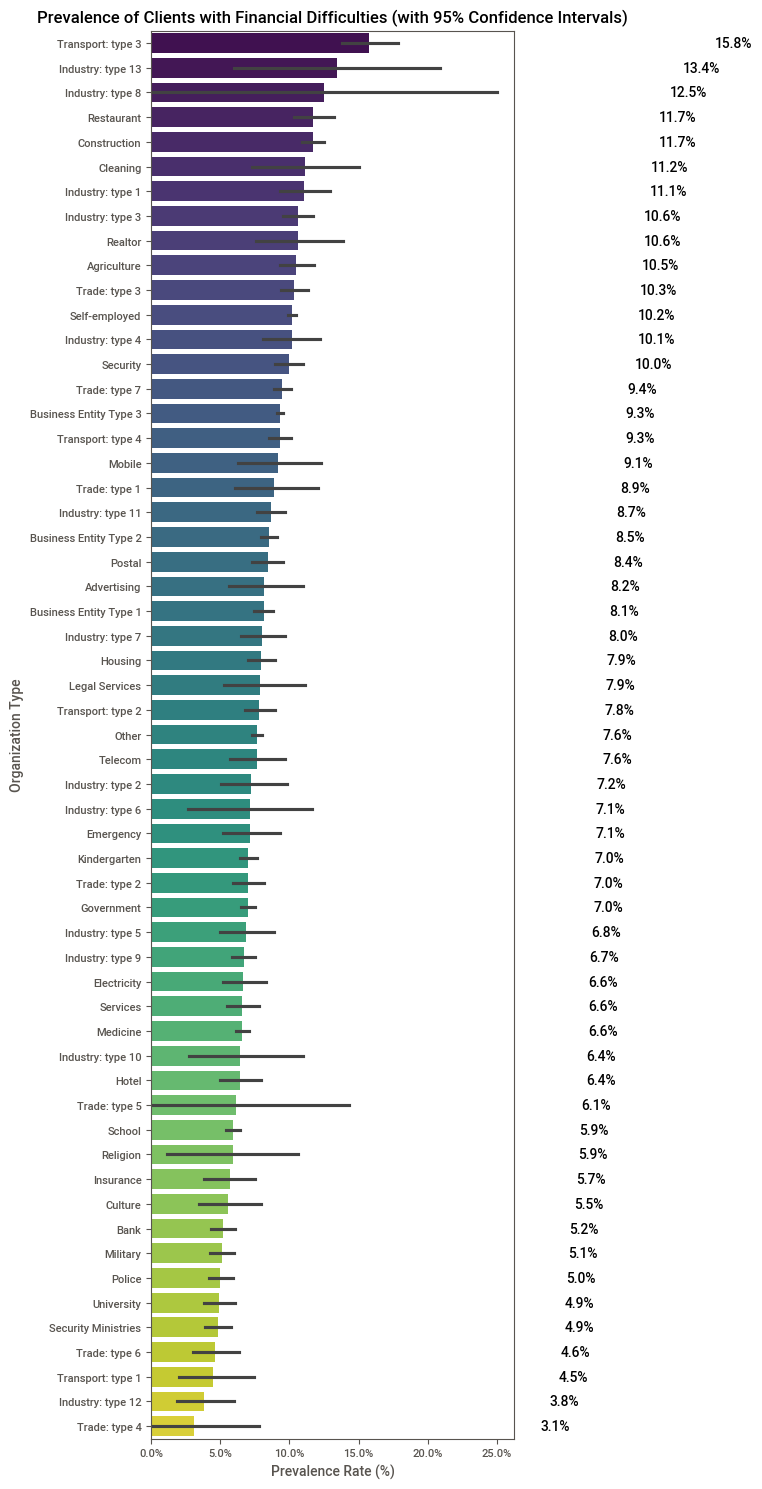

In [ ]:
from matplotlib.ticker import PercentFormatter

# Calculate mean TARGET per organization, sorted descending
mean_target = (
    final_df.groupby("ORGANIZATION_TYPE")["TARGET"]
    .mean()
    .sort_values(ascending=False)
)
order = mean_target.index

plt.figure(figsize=(10, 15))
ax = sns.barplot(
    data=final_df,
    y="ORGANIZATION_TYPE",
    x="TARGET",
    order=order,
    errorbar="ci",
    palette="viridis",
)

# Format x-axis as percentages
ax.xaxis.set_major_formatter(PercentFormatter(1.0))

# Add annotations on the right of bars
for i, val in enumerate(mean_target):
    ax.text(
        val + 0.25,  # position just right of the bar
        i,  # y position (matches bar index)
        f"{val*100:.1f}%",  # label text as percentage with one decimal
        va="center",
        ha="left",
        fontsize=10,
        color="black",
    )

plt.ylabel("Organization Type")
plt.xlabel("Prevalence Rate (%)")
plt.title(
    "Prevalence of Clients with Financial Difficulties (with 95% Confidence Intervals)"
)
plt.tight_layout()
plt.show()

- As we can see the prevalence of clients with financial difficulties differ significantly across different organization types
- The highest prevalence has Transport type 3, Industry type 8 and 13
- Transport Type 3 – Road Freight (e.g., trucking, logistics) - High fuel costs, thin profit margins, delayed payments, and dependency on contracts make them vulnerable to cash flow issues.
- Industry Type 8 – Construction - Project delays, upfront material costs, seasonal demand, and reliance on client payments often cause cash flow instability.
- Industry Type 13 – Manufacturing (especially small-scale or heavy industry) - Capital-intensive operations, equipment loans, volatile raw material prices, and market fluctuations can lead to high debt and low liquidity.

What is the relationship between length of employment and organization type with respect to a client’s risk of financial difficulties?

##### DAYS_EMPLOYED

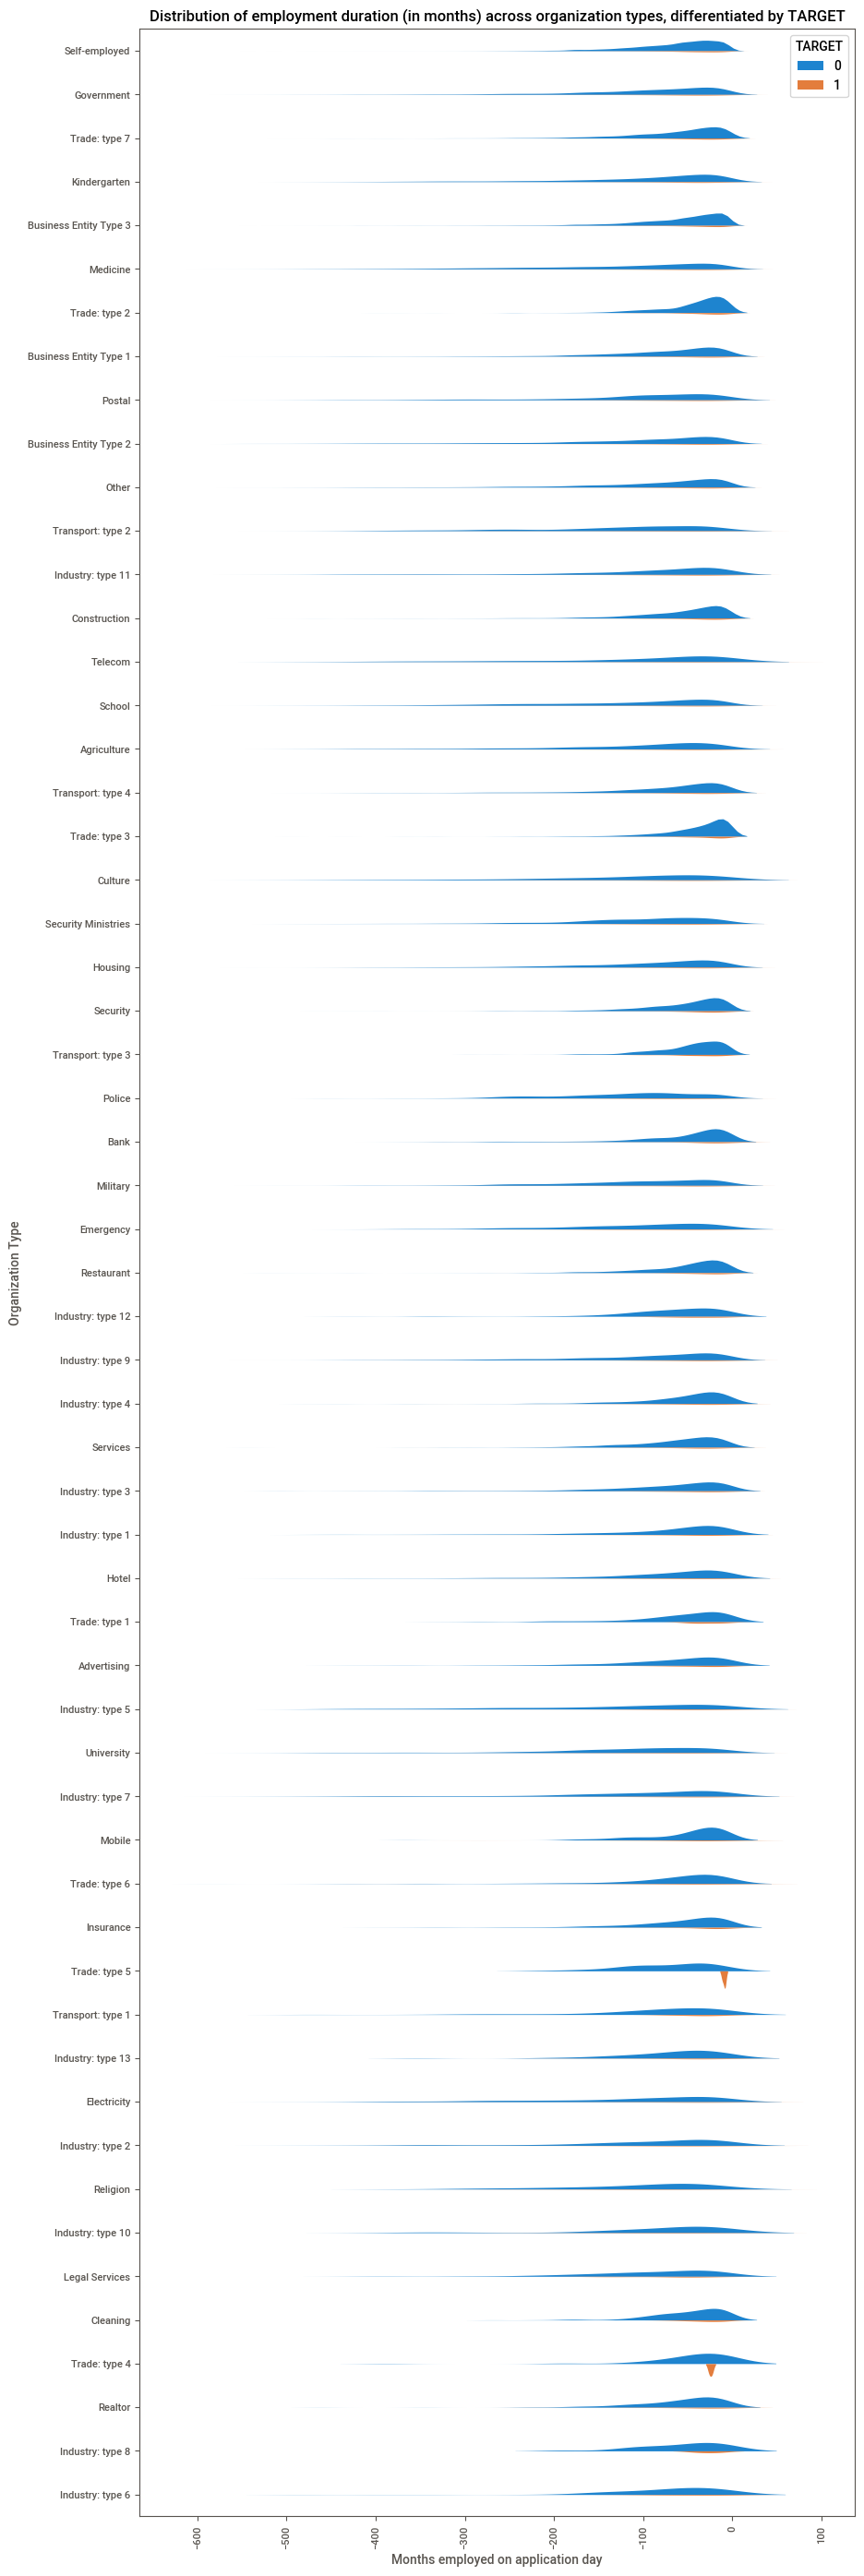

In [ ]:
plt.figure(figsize=(10, 35))
sns.violinplot(
    data=final_df,
    y=final_df["ORGANIZATION_TYPE"],
    x=final_df["DAYS_EMPLOYED"] / 30,
    hue="TARGET",
    split=True,
    linewidth=0,
)
plt.xlabel("Months employed on application day")
plt.ylabel("Organization Type")
plt.title(
    "Distribution of employment duration (in months) across organization types, differentiated by TARGET"
)
plt.xticks(rotation=90)

- we can see that some sample distribution for Industry type 4 and 8 with TARGET = 1 are right shifted (towards less employment length)  and much more narrow (without tails) then other. People from this industries and in this employed period have higher chance for having financial difficulties with a credit.
- Trade Type 4 – Retail Trade (Small-scale Retailers & Shops) =  Small margins, high competition, vulnerability to market shifts (e.g., online shopping), and fluctuating customer demand can cause unstable revenue and weak repayment capacity.
- Trade Type 5 – Wholesale Trade - High inventory costs, tight cash flow cycles, dependence on buyer solvency, and price volatility make wholesalers sensitive to delays and defaults.

##### EXT_SOURCE_* features

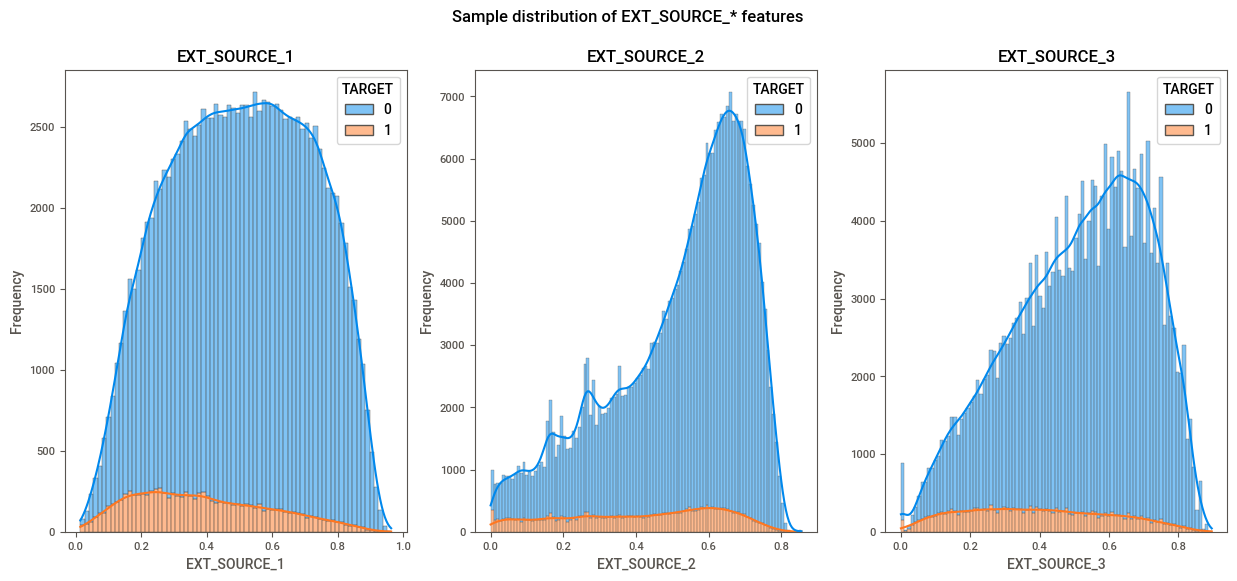

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle("Sample distribution of EXT_SOURCE_* features")

axes = axes.flatten()

for i, column in enumerate(
    [
        "EXT_SOURCE_1",
        "EXT_SOURCE_2",
        "EXT_SOURCE_3",
    ]
):
    sns.histplot(
        data=final_df,
        x=column,
        ax=axes[i],
        hue="TARGET",
        multiple="stack",
        kde=True,
    )

    axes[i].set_title(f"{column}")
    axes[i].set_xlabel(f"{column}")
    axes[i].set_ylabel("Frequency")

- We can see vivid trend of decreasing proportion of clients with financial difficulties, as their score from external source increases

##### AMT_CREDIT

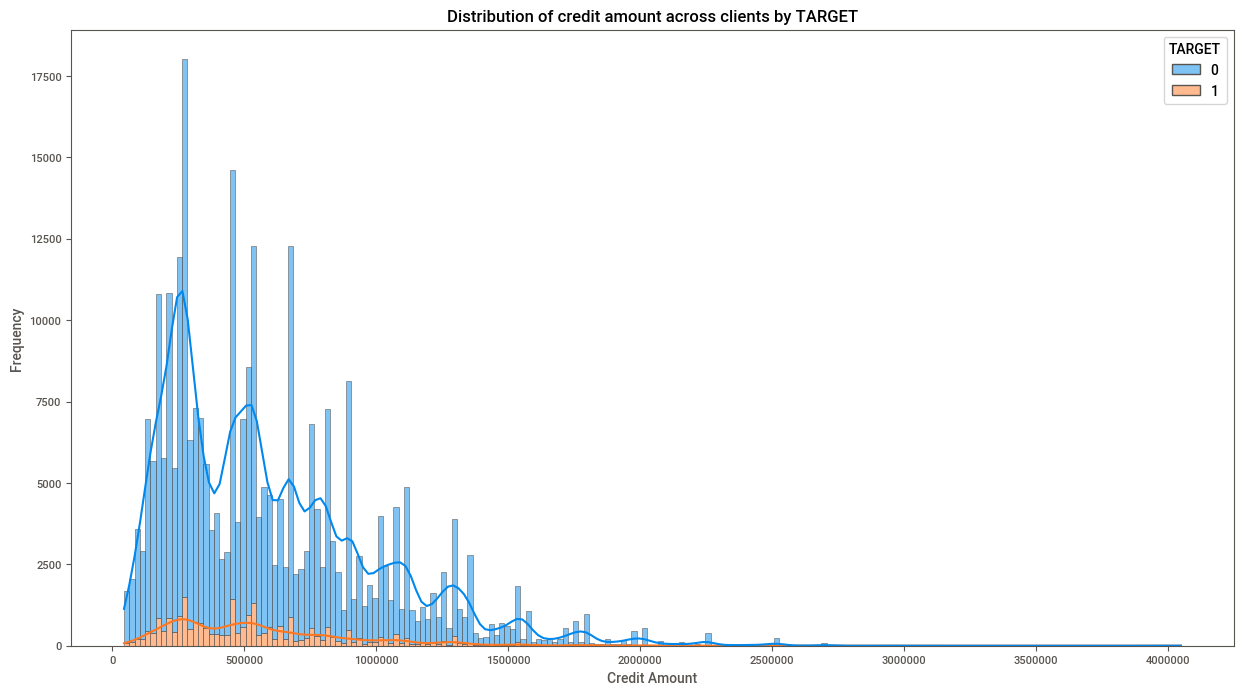

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(
    data=final_df,
    x="AMT_CREDIT",
    hue="TARGET",
    multiple="stack",
    bins=200,
    kde=True,
)
plt.xlabel("Credit Amount")
plt.ylabel("Frequency")
plt.title("Distribution of credit amount across clients by TARGET")
plt.show()

- Credits for around 250k and 500k are the most frequent ones
- The blue kde curve is quite wavy with peaks around rounded numbers such as 0.25M, 0.5M, 1M, 1.25M, 1.5M, 1.75 2M. The possible reason is the popularity of applying for rounded loan amounts

##### DAYS_BIRTH

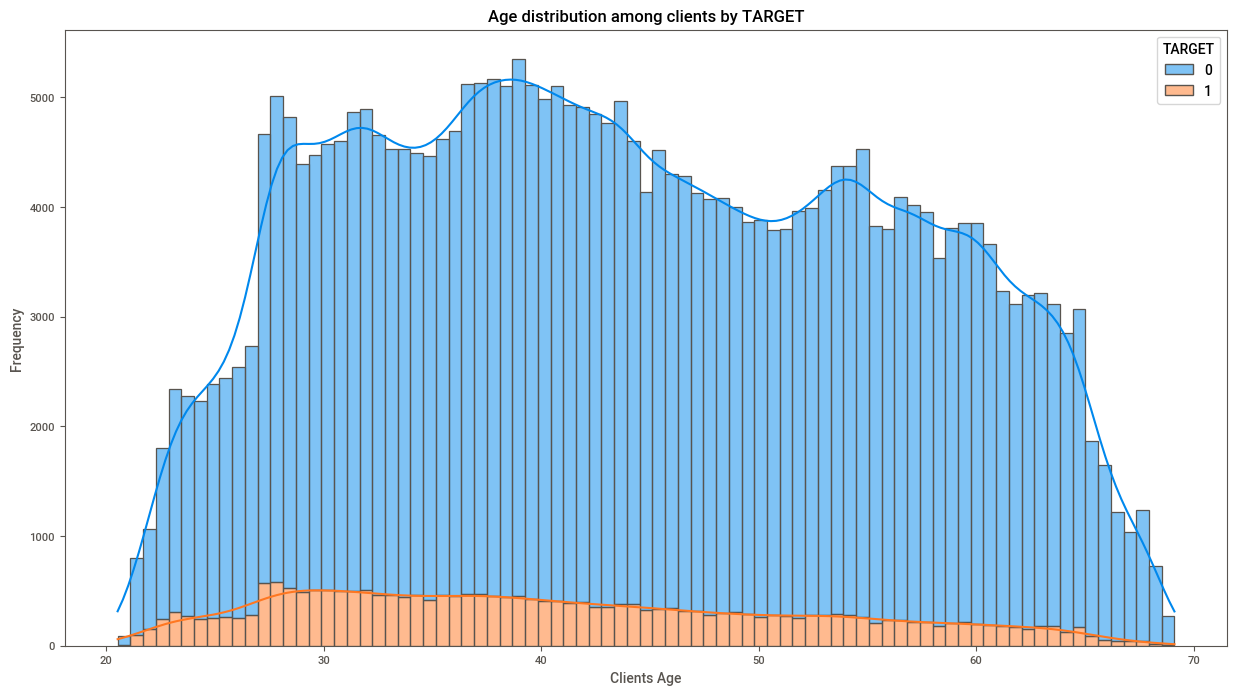

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(
    data=final_df,
    x=abs(final_df["DAYS_BIRTH"] / 365),  # Convert to years and make positive
    hue="TARGET",
    multiple="stack",
    kde=True,
)
plt.xlabel("Clients Age")
plt.ylabel("Frequency")
plt.title("Age distribution among clients by TARGET")
plt.show()

- Younger clients until around 27 yo, create higher credit risk
- Clients under 20 can not have credits (or there were no such clients in the dataset)

# END OF PART I
# NAVIGATE TO PART II